## Описание проекта. Телеком

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Ваша задача — обучить на этих данных модель для прогноза оттока клиентов.


In [ ]:
!pip install scikeras
!pip install phik

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.5/679.5 kB 9.1 MB/s eta 0:00:00


Загрузим библиотеки с которыми будем работать.

In [ ]:
import numpy as np
import pandas as pd
import psycopg2
import phik
import datetime
import matplotlib.pyplot as plt

from psycopg2 import sql
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import tree, metrics
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from scipy.stats import shapiro
from seaborn import heatmap
from scikeras.wrappers import KerasRegressor

## 1. Загрузим данные.
Подключимся к базе данных, используя для этого код:

In [ ]:
db_config = {
    'user': 'praktikum_student',# имя пользователя,
    'pwd': '********',# пароль,
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432,# порт подключения,
    'db': 'data-science-final'# название базы данных,
}
RANDOM_STATE = 140523

sql соединение курсор для sql запросов

In [ ]:
conn = psycopg2.connect(
    host = db_config['host'],
    user = db_config['user'],
    password = db_config['pwd'],
    database = db_config['db'],
    port = db_config['port']
)
cursor = conn.cursor()

перевод sql запросов на новый язык, сами sql запросы -- выбор всех ячеек из заданых таблиц

In [ ]:
tablesGetNames = ['telecom.contract', 'telecom.personal', 'telecom.internet', 'telecom.phone']
queriesSQLTable=list(map(lambda x: sql.SQL('SELECT * FROM ' + x ), tablesGetNames))
queriesSQLHead=list(map(lambda x: sql.SQL('SELECT * FROM INFORMATION_SCHEMA.COLUMNS WHERE TABLE_NAME = '+x), tablesGetNames))

запрос и добавление в общий список "сырых" таблиц

In [ ]:
tablesRaw = []
headsRaw = []
for i in queriesSQLTable:
    cursor.execute(i)
    tablesRaw.append(cursor.fetchall())
    headsRaw.append(cursor.description)

закрытие курсора и соединения

In [ ]:
cursor.close()
conn.close()

## 2. Проведем исследовательский анализ и предобработку данных

Перевод "сырых" таблиц, попытка взять названия колонок из базы неудачная (2 последних без названий), потому забиваю от руки

In [ ]:
headsSQL=list(map(
    lambda x: list(map(lambda y: y.name, x)),
    headsRaw
))
headsSQL

[['customerID',
  'BeginDate',
  'EndDate',
  'Type',
  'PaperlessBilling',
  'PaymentMethod',
  'MonthlyCharges',
  'TotalCharges'],
 ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents'],
 ['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8'],
 ['c1', 'c2']]

но при исследовании выяснилось, что эти 2 таблицы содержат названия колоннок неформатно в 1й строчке

In [ ]:
[tablesRaw[2][0],tablesRaw[3][0]]

[('customerID',
  'InternetService',
  'OnlineSecurity',
  'OnlineBackup',
  'DeviceProtection',
  'TechSupport',
  'StreamingTV',
  'StreamingMovies'),
 ('customerID', 'MultipleLines')]

поэтому странными способами получаются заголовки и таблицы

In [ ]:
heads = headsSQL[:2]
list(map(lambda x: heads.append(list(tablesRaw[2+x][0])),range(2)))
heads

[['customerID',
  'BeginDate',
  'EndDate',
  'Type',
  'PaperlessBilling',
  'PaymentMethod',
  'MonthlyCharges',
  'TotalCharges'],
 ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents'],
 ['customerID',
  'InternetService',
  'OnlineSecurity',
  'OnlineBackup',
  'DeviceProtection',
  'TechSupport',
  'StreamingTV',
  'StreamingMovies'],
 ['customerID', 'MultipleLines']]

In [ ]:
tablesRaw2 = tablesRaw[:2]
list(map(lambda x: tablesRaw2.append(tablesRaw[2+x][1:]), range(2)))
list(map(lambda x: x[0], tablesRaw2))

[('4472-LVYGI',
  datetime.date(2020, 2, 1),
  None,
  'Two year',
  'Yes',
  'Bank transfer (automatic)',
  Decimal('52.55'),
  None),
 ('7590-VHVEG', 'Female', 0, 'Yes', 'No'),
 ('7590-VHVEG', 'DSL', 'No', 'Yes', 'No', 'No', 'No', 'No'),
 ('5575-GNVDE', 'No')]

In [ ]:
tables = list(map(lambda x: pd.DataFrame(tablesRaw2[x],columns=heads[x]),range(len(heads))))
[contractDf,personalDf,internetDf,phoneDf] = tables

In [ ]:
contractDf

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,None
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,None
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,None
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.7,151.65
...,...,...,...,...,...,...,...,...
7038,2569-WGERO,2019-01-21,None,Two year,Yes,Bank transfer (automatic),21.15,1419.4
7039,6840-RESVB,2019-02-26,None,One year,Yes,Mailed check,84.8,1990.5
7040,2234-XADUH,2019-09-02,None,One year,Yes,Credit card (automatic),103.2,7362.9
7041,4801-JZAZL,2019-06-26,None,Month-to-month,Yes,Electronic check,29.6,346.45


2.1 Посмотрим, все ли таблицы содержат данные, Соответствует ли количество таблиц условию задачи.

Длина таблиц

In [ ]:
list(map(lambda x: print(len(x)), tables))

7043
7043
5517
6361


[None, None, None, None]

Длина уникальных **customerID**

In [ ]:
list(map(lambda x: print(len(x['customerID'].unique())), tables))

7043
7043
5517
6361


[None, None, None, None]

Вывод: каждая таблица содержит данные т.к. длина > 0

2.2 Проведем исследовательский анализ данных: проверим наличие пропусков и аномалий, изучим распределение признаков.

In [ ]:
tables[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        7043 non-null   object
 1   BeginDate         7043 non-null   object
 2   EndDate           1869 non-null   object
 3   Type              7043 non-null   object
 4   PaperlessBilling  7043 non-null   object
 5   PaymentMethod     7043 non-null   object
 6   MonthlyCharges    7043 non-null   object
 7   TotalCharges      7032 non-null   object
dtypes: object(8)
memory usage: 440.3+ KB


In [ ]:
list(map(lambda x: x.info(), tables))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        7043 non-null   object
 1   BeginDate         7043 non-null   object
 2   EndDate           1869 non-null   object
 3   Type              7043 non-null   object
 4   PaperlessBilling  7043 non-null   object
 5   PaymentMethod     7043 non-null   object
 6   MonthlyCharges    7043 non-null   object
 7   TotalCharges      7032 non-null   object
dtypes: object(8)
memory usage: 440.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non

[None, None, None, None]

In [ ]:
list(map(lambda x: x.isnull().values.any(), tables))

[True, False, False, False]

Вывод: в первой таблице присутствуют нулевые значения

2.3 Обработаем аномалии с учётом особенностей услуг телекоммуникации.

Вывод: будут обработаны в процессе объединения таблиц и поиска новых признаков

2.4 Выделим в целевую переменную признак **EndDate**.

Функция, которая переделывает колонку **EndDate** в таргетовые значения:
    1, если услуга продолжается (хороший результат)
    0, если услуга была отменена (плохой результат)

In [ ]:
def Nan2One(x):
    if x == None:
        return False
    else:
        return True

In [ ]:
contractDfEnded = contractDf.copy()
contractDfEnded.insert(3,'targetEnded',contractDfEnded['EndDate'].apply(Nan2One))
contractDfEnded

,customerID,BeginDate,EndDate,targetEnded,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,False,Two year,Yes,Bank transfer (automatic),52.55,None
1,3115-CZMZD,2020-02-01,None,False,Two year,No,Mailed check,20.25,None
2,3668-QPYBK,2018-08-09,2019-12-01,True,Month-to-month,Yes,Mailed check,53.85,108.15
3,5709-LVOEQ,2020-02-01,None,False,Two year,No,Mailed check,80.85,None
4,9237-HQITU,2019-01-26,2019-11-01,True,Month-to-month,Yes,Electronic check,70.7,151.65
...,...,...,...,...,...,...,...,...,...
7038,2569-WGERO,2019-01-21,None,False,Two year,Yes,Bank transfer (automatic),21.15,1419.4
7039,6840-RESVB,2019-02-26,None,False,One year,Yes,Mailed check,84.8,1990.5
7040,2234-XADUH,2019-09-02,None,False,One year,Yes,Credit card (automatic),103.2,7362.9
7041,4801-JZAZL,2019-06-26,None,False,Month-to-month,Yes,Electronic check,29.6,346.45


Вывод: признак **EndDate** выделен

2.5 Попробуем сгенерировать новые признаки, которые могут пригодится при обучении. Например, рассчитаем длительность контракта абонента.

In [ ]:
types = contractDfEnded['Type'].drop_duplicates().sort_values().tolist()
dfsEndDateTypes = list(map(lambda x: contractDfEnded[['EndDate','Type']].dropna().loc[contractDfEnded[['EndDate','Type']].dropna()['Type']==x], types))
list(map(lambda x: print('количество окончаний услуг:', dfsEndDateTypes[x]['EndDate'].size, 'тип:', types[x]), range(3)))
print('количество окончаний услуг:', contractDfEnded['EndDate'].dropna().size, 'тип: всего')

количество окончаний услуг: 1655 тип: Month-to-month
количество окончаний услуг: 166 тип: One year
количество окончаний услуг: 48 тип: Two year
количество окончаний услуг: 1869 тип: всего


кроме помесячного типа оплаты выглядит не очень многообещающе, можно попробовать увеличить количество добавив **EndDate** клиентам, срок предоставления услуг которым ещё не закончился

In [ ]:
list(map(lambda x: print('размер:',contractDfEnded[contractDfEnded['Type']==x]['Type'].size,'тип:', x), types))
print('размер:', contractDfEnded['Type'].size, 'тип: всего')

размер: 3875 тип: Month-to-month
размер: 1473 тип: One year
размер: 1695 тип: Two year
размер: 7043 тип: всего


рассчитываются временные даты окончания для клиентов без даты окончания<br>
для этого ищется последняя зафиксированная дата окончания и, к начальным датам клиентов без даты окончания прибавляется их временной период, пока сумма не привысит посоеднюю зафиксированую дату окончания<br>
то есть для того, чтобы было численное значение периода предоставления услуг без даты окончания, считается что эти клиенты не продлят услуги в следующий момент оплаты<br><br>

так как периоды предоставления услуг разные, то возникает вопрос как их обрабатывать потом:<br>
    &nbsp;&nbsp;&nbsp;&nbsp;
    вариант 1: обрабатывать по периоду<br>
    &nbsp;&nbsp;&nbsp;&nbsp;
    вариант 2: выбрать дату "среза"<br>
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
        вариант 2.1: дата среза -- следующий месяц (несправедливо к более длительным  временным периодам)<br>
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
        вариант 2.2: дата среза -- самая последняя временная дата (неадекватная репрезентация более коротких временных периодов)<br>
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
        вариант 2.3: дата среза -- некое среднее между следующим месяцом и максимальной датой (средннее арифмитическое, среднее пропорцианальное)<br>

функция для обработки периодов в количестве месяцев

In [ ]:
def RealPeriod(period):
    if period[1] == None :
        return None
    else:
        perRel = relativedelta(period[1], period[0])
        return perRel.years * 12 + perRel.months

дата после которой услуги ещё не продлевались

In [ ]:
maxEndDate = datetime.date(2020, 3, 1)

In [ ]:
typesDict = dict(np.transpose([types, [relativedelta(months=1), relativedelta(months=12), relativedelta(months=24)]]))

вычисление "временной" даты окончания услуг

In [ ]:
def TempEndDate(perV):
    [beg, end, typ]=perV
    if end != None :
        return end
    else:
        tTemp = beg
        dt = typesDict[typ]
        while tTemp < maxEndDate:
            tTemp = tTemp + dt
        return tTemp

In [ ]:
contractDfDt = contractDfEnded.copy()
contractDfDt.insert(4,'dtReal', contractDfDt[['BeginDate','EndDate']].apply(RealPeriod, axis = 1))
contractDfDt.insert(3,'EndDateTemp', contractDfDt[['BeginDate','EndDate','Type']].apply(TempEndDate, axis = 1))
contractDfDt.insert(6,'dtTemp', contractDfDt[['BeginDate','EndDateTemp']].apply(RealPeriod, axis = 1))
contractDfDt

,customerID,BeginDate,EndDate,EndDateTemp,targetEnded,dtReal,dtTemp,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,2022-02-01,False,NaN,24,Two year,Yes,Bank transfer (automatic),52.55,None
1,3115-CZMZD,2020-02-01,None,2022-02-01,False,NaN,24,Two year,No,Mailed check,20.25,None
2,3668-QPYBK,2018-08-09,2019-12-01,2019-12-01,True,15.0,15,Month-to-month,Yes,Mailed check,53.85,108.15
3,5709-LVOEQ,2020-02-01,None,2022-02-01,False,NaN,24,Two year,No,Mailed check,80.85,None
4,9237-HQITU,2019-01-26,2019-11-01,2019-11-01,True,9.0,9,Month-to-month,Yes,Electronic check,70.7,151.65
...,...,...,...,...,...,...,...,...,...,...,...,...
7038,2569-WGERO,2019-01-21,None,2021-01-21,False,NaN,24,Two year,Yes,Bank transfer (automatic),21.15,1419.4
7039,6840-RESVB,2019-02-26,None,2021-02-26,False,NaN,24,One year,Yes,Mailed check,84.8,1990.5
7040,2234-XADUH,2019-09-02,None,2020-09-02,False,NaN,12,One year,Yes,Credit card (automatic),103.2,7362.9
7041,4801-JZAZL,2019-06-26,None,2020-03-26,False,NaN,9,Month-to-month,Yes,Electronic check,29.6,346.45


рассматриваются итоги вычислений новых дат окончания

In [ ]:
typesPresent1 = list(map(lambda x: contractDfDt.loc[contractDfDt['Type'] == x], types))
typesPresent2 = list(map(lambda x: [x.loc[x['EndDate'].isna()], x.loc[x['EndDate'].notna()]], typesPresent1))
typesPresentAll = [contractDfDt.loc[contractDfDt['EndDate'].isna()],contractDfDt.loc[contractDfDt['EndDate'].notna()]]

In [ ]:
display('добавленные промежутки',typesPresentAll[0]['dtTemp'].value_counts().sort_index(),'реальные промежутки',typesPresentAll[1]['dtTemp'].value_counts().sort_index())

'добавленные промежутки'

2        1
3        4
4       10
5       22
6       52
7      106
8      176
9      243
10     304
11     318
12    1180
13     275
14     173
15     117
16      74
17      27
18      10
19       6
20       2
21       1
24    2073
Name: dtTemp, dtype: int64

'реальные промежутки'

1       3
2      12
3      22
4      43
5      68
6     128
7     192
8     228
9     282
10    269
11    223
12    153
13    114
14     62
15     38
16     23
17      7
18      2
Name: dtTemp, dtype: int64

данные с новыми промежутками<br>
при исследовании видно что на реальных данных пока ни один клиент с типом услуги на 2 года не довёл эту услугу до конца заданного периода, так что возможно придётся отрезать/добавить новые границы<br><br>
и появляется интересный признак "отказ от услуг до их полного выполнения"

просмотр новых периодов по типам

In [ ]:
i = 0
print('тип:',types[i])
display('добавленные промежутки',typesPresent2[i][0]['dtTemp'].value_counts().sort_index(),'реальные промежутки',typesPresent2[i][1]['dtTemp'].value_counts().sort_index())

тип: Month-to-month


'добавленные промежутки'

2       1
3       4
4      10
5      22
6      52
7     106
8     176
9     243
10    304
11    318
12    299
13    275
14    173
15    117
16     74
17     27
18     10
19      6
20      2
21      1
Name: dtTemp, dtype: int64

'реальные промежутки'

1       2
2      10
3      21
4      37
5      62
6     109
7     173
8     204
9     248
10    240
11    198
12    133
13     99
14     56
15     33
16     21
17      7
18      2
Name: dtTemp, dtype: int64

In [ ]:
i = 1
print('тип:',types[i])
display('добавленные промежутки',typesPresent2[i][0]['dtTemp'].value_counts().sort_index(),'реальные промежутки',typesPresent2[i][1]['dtTemp'].value_counts().sort_index())

тип: One year


'добавленные промежутки'

12    881
24    426
Name: dtTemp, dtype: int64

'реальные промежутки'

1      1
2      2
4      6
5      4
6     18
7     14
8     18
9     27
10    23
11    18
12    13
13    12
14     4
15     5
16     1
Name: dtTemp, dtype: int64

In [ ]:
i = 2
print('тип:',types[i])
display('добавленные промежутки',typesPresent2[i][0]['dtTemp'].value_counts().sort_index(),'реальные промежутки',typesPresent2[i][1]['dtTemp'].value_counts().sort_index())

тип: Two year


'добавленные промежутки'

24    1647
Name: dtTemp, dtype: int64

'реальные промежутки'

3     1
5     2
6     1
7     5
8     6
9     7
10    6
11    7
12    7
13    3
14    2
16    1
Name: dtTemp, dtype: int64

видно, что, если придётся использовать дополнительно установленные периоды, то только для типов за месяц, но лучше воспользоваться лишь заданными изначально

добавляется признак "остаток месяцев при прирывании услуги" - **nBreak**

In [ ]:
def NBreak(row):
    [dtReal, typ] = row
    if dtReal == None:
        return 0
    else:
        period = typesDict[typ].years * 12 + typesDict[typ].months
        if dtReal < period:
            return period - dtReal
        else:
            return 0

In [ ]:
contractDfBreak = contractDfDt.copy()
contractDfBreak.insert(12, 'nBreak', contractDfBreak[['dtReal','Type']].apply(NBreak, axis = 1))
contractDfBreak

,customerID,BeginDate,EndDate,EndDateTemp,targetEnded,dtReal,dtTemp,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,nBreak
0,4472-LVYGI,2020-02-01,None,2022-02-01,False,NaN,24,Two year,Yes,Bank transfer (automatic),52.55,None,0.0
1,3115-CZMZD,2020-02-01,None,2022-02-01,False,NaN,24,Two year,No,Mailed check,20.25,None,0.0
2,3668-QPYBK,2018-08-09,2019-12-01,2019-12-01,True,15.0,15,Month-to-month,Yes,Mailed check,53.85,108.15,0.0
3,5709-LVOEQ,2020-02-01,None,2022-02-01,False,NaN,24,Two year,No,Mailed check,80.85,None,0.0
4,9237-HQITU,2019-01-26,2019-11-01,2019-11-01,True,9.0,9,Month-to-month,Yes,Electronic check,70.7,151.65,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,2569-WGERO,2019-01-21,None,2021-01-21,False,NaN,24,Two year,Yes,Bank transfer (automatic),21.15,1419.4,0.0
7039,6840-RESVB,2019-02-26,None,2021-02-26,False,NaN,24,One year,Yes,Mailed check,84.8,1990.5,0.0
7040,2234-XADUH,2019-09-02,None,2020-09-02,False,NaN,12,One year,Yes,Credit card (automatic),103.2,7362.9,0.0
7041,4801-JZAZL,2019-06-26,None,2020-03-26,False,NaN,9,Month-to-month,Yes,Electronic check,29.6,346.45,0.0


In [ ]:
contractDfBreak[['dtReal','Type']].apply(NBreak, axis = 1).value_counts()

0.0     6864
3.0       27
2.0       23
6.0       18
1.0       18
4.0       18
5.0       14
8.0        7
12.0       7
15.0       7
13.0       7
16.0       6
14.0       6
17.0       5
10.0       4
7.0        4
11.0       4
19.0       2
18.0       1
21.0       1
dtype: int64

In [ ]:
contractDfBreakYears = contractDfBreak.loc[contractDfBreak['Type'] == types[1]]
contractDfBreakYears1 = contractDfBreakYears.loc[contractDfBreakYears['EndDate'].notna()]['nBreak']
contractDfBreakYears2 = contractDfBreakYears.loc[contractDfBreakYears['EndDate'].isna()]
contractDfBreakYears2 = contractDfBreakYears2.loc[contractDfBreakYears2['dtTemp']>12]
print(contractDfBreakYears1.loc[contractDfBreakYears1>0].size, 'услуг было прервано из всего', len(contractDfBreakYears), 'типа', types[1], 'из которых завершены:', len(contractDfBreakYears1), 'и прошли больше одного цикла:', len(contractDfBreakYears2))
contractDfBreak2Years = contractDfBreak.loc[contractDfBreak['Type'] == types[2]]
contractDfBreak2Years1 = contractDfBreak2Years.loc[contractDfBreak2Years['EndDate'].notna()]['nBreak']
contractDfBreak2Years2 = contractDfBreak2Years.loc[contractDfBreak2Years['EndDate'].isna()]
contractDfBreak2Years2 = contractDfBreak2Years2.loc[contractDfBreak2Years2['dtTemp']>24]
print(contractDfBreak2Years1.loc[contractDfBreak2Years1>0].size, 'услуг было прервано из всего', len(contractDfBreak2Years), 'типа', types[2], 'из которых завершены:', len(contractDfBreak2Years1), 'и прошли больше одного цикла:', len(contractDfBreak2Years2))

131 услуг было прервано из всего 1473 типа One year из которых завершены: 166 и прошли больше одного цикла: 426
48 услуг было прервано из всего 1695 типа Two year из которых завершены: 48 и прошли больше одного цикла: 0


На этих данных видно, что не все услуги выполняются в полном заданном объёме, поэтому принимаю решение "обрезать" объёмы временных **EndDate** следующим месяцем (1 марта 2020)<br>
Например, раньше если оказывание услуг сроком 2 года начиналось в 1 января 2020 года, датой окончания считалась 1 января 2022 года. Но на основе исследования прерываний видно что такие "длинные" услуги могут выполнятся не в полном объёме, поэтому считаю возможным ограничить все неуказанные **EndDate** 1м марта 2020.

При повторном исследовании возникло понимание, что вывод оказался поспешным.  
Было предано слишком большое значение тому, что все законченные услуги были прерваны раньше своего окончания, а значит что и для данного проекта их можно "прервать".  
Доп исследование ниже.

In [ ]:
contractDfBreak2Years = contractDfBreak.loc[contractDfBreak['Type'] == types[2]]
addResearch1 = contractDfBreak2Years['BeginDate'].apply(lambda x: str((x.year, x.month))).value_counts()
addResearch1 = addResearch1.rename('BeginDateTotal')
addResearch1

(2019, 4)     246
(2019, 3)     235
(2019, 5)     213
(2019, 2)     187
(2019, 6)     185
(2019, 1)     142
(2019, 7)     134
(2018, 12)     91
(2019, 8)      66
(2018, 11)     53
(2019, 9)      43
(2018, 10)     31
(2018, 9)      18
(2019, 10)     18
(2020, 2)      10
(2019, 11)      9
(2018, 8)       5
(2019, 12)      4
(2018, 7)       3
(2018, 6)       1
(2020, 1)       1
Name: BeginDateTotal, dtype: int64

In [ ]:
addResearch2 = contractDfBreak2Years.loc[contractDfBreak2Years['targetEnded']==True]['BeginDate'].apply(lambda x: str((x.year, x.month))).value_counts()
addResearch2 = addResearch2.rename('BeginDateEnded')
addResearch2

(2019, 3)     7
(2019, 1)     7
(2018, 11)    7
(2019, 2)     5
(2018, 10)    5
(2018, 12)    5
(2019, 4)     3
(2018, 8)     2
(2018, 9)     2
(2019, 7)     1
(2018, 6)     1
(2019, 6)     1
(2019, 8)     1
(2019, 5)     1
Name: BeginDateEnded, dtype: int64

<Axes: >

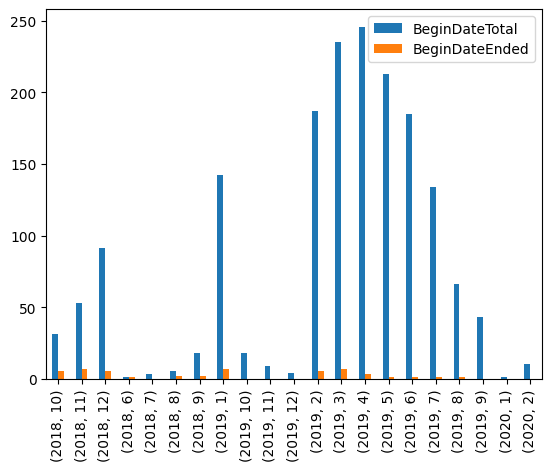

In [ ]:
addResearch = pd.concat([addResearch1, addResearch2], axis = 1)
addResearch['BeginDateEnded'] = addResearch['BeginDateEnded'].fillna(0).apply(int)
addResearch.sort_index().plot(kind = 'bar')

После провдения доп исследования стало понятно что, несмотря на то, что ещё ни один "цикл" услуг с типом оплаты "Два года" ещё не был полностью выполнен, прерыввания это лишь незначительная часть от общих услуг. Поэтому однозначно "обрезать" дату для этого типа услуг -- неправильно и новые данные будут пересчитаны на "мнимую" дату окончания (дата начала +24 месяца, в случае типа "Два года").  

В следующей ячейке -- как раз способ, от которого отказываюсь.

In [ ]:
contractDfDtNew = contractDfBreak.drop(columns = ['EndDateTemp','dtTemp'])
contractDfDtNew.insert(3,'EndDateTemp', contractDfDtNew['EndDate'].fillna(maxEndDate))
contractDfDtNew.insert(6,'dtTemp', contractDfDtNew[['BeginDate','EndDateTemp']].apply(RealPeriod, axis = 1))
contractDfDtNew

,customerID,BeginDate,EndDate,EndDateTemp,targetEnded,dtReal,dtTemp,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,nBreak
0,4472-LVYGI,2020-02-01,None,2020-03-01,False,NaN,1,Two year,Yes,Bank transfer (automatic),52.55,None,0.0
1,3115-CZMZD,2020-02-01,None,2020-03-01,False,NaN,1,Two year,No,Mailed check,20.25,None,0.0
2,3668-QPYBK,2018-08-09,2019-12-01,2019-12-01,True,15.0,15,Month-to-month,Yes,Mailed check,53.85,108.15,0.0
3,5709-LVOEQ,2020-02-01,None,2020-03-01,False,NaN,1,Two year,No,Mailed check,80.85,None,0.0
4,9237-HQITU,2019-01-26,2019-11-01,2019-11-01,True,9.0,9,Month-to-month,Yes,Electronic check,70.7,151.65,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,2569-WGERO,2019-01-21,None,2020-03-01,False,NaN,13,Two year,Yes,Bank transfer (automatic),21.15,1419.4,0.0
7039,6840-RESVB,2019-02-26,None,2020-03-01,False,NaN,12,One year,Yes,Mailed check,84.8,1990.5,0.0
7040,2234-XADUH,2019-09-02,None,2020-03-01,False,NaN,5,One year,Yes,Credit card (automatic),103.2,7362.9,0.0
7041,4801-JZAZL,2019-06-26,None,2020-03-01,False,NaN,8,Month-to-month,Yes,Electronic check,29.6,346.45,0.0


Отказываюсь от вычислений с сохранением структуры программы.

In [ ]:
contractDfDtNew = contractDfBreak.copy()

повторяю анализ

In [ ]:
typesPresentAllNew = [contractDfDtNew.loc[contractDfDtNew['EndDate'].isna()], contractDfDtNew.loc[contractDfDt['EndDate'].notna()]]

In [ ]:
display('добавленные промежутки', typesPresentAllNew[0]['dtTemp'].value_counts().sort_index(), 'реальные промежутки', typesPresentAllNew[1]['dtTemp'].value_counts().sort_index())

'добавленные промежутки'

2        1
3        4
4       10
5       22
6       52
7      106
8      176
9      243
10     304
11     318
12    1180
13     275
14     173
15     117
16      74
17      27
18      10
19       6
20       2
21       1
24    2073
Name: dtTemp, dtype: int64

'реальные промежутки'

1       3
2      12
3      22
4      43
5      68
6     128
7     192
8     228
9     282
10    269
11    223
12    153
13    114
14     62
15     38
16     23
17      7
18      2
Name: dtTemp, dtype: int64

раз установлен период, можно вычислить общие расходы абонента

In [ ]:
dfTotalCharges = contractDfDt.loc[contractDfDt['TotalCharges'].notna()]
dfTotalCharges.insert(12,'TotalChargesTemp',dfTotalCharges[['dtTemp','MonthlyCharges']].apply(lambda x: x[0] * x[1], axis = 1))
dfTotalCharges.insert(13,'TotalChargesD',dfTotalCharges[['TotalCharges','TotalChargesTemp']].apply(lambda x: x[0] - x[1], axis = 1))
display(dfTotalCharges['TotalChargesD'].value_counts())
display(dfTotalCharges['TotalChargesD'].value_counts().sort_index())

-262.6     5
-437.4     4
-162.00    4
-20.05     3
-381.80    3
          ..
1262.2     1
971.2      1
-249.5     1
-639.9     1
4308.90    1
Name: TotalChargesD, Length: 6711, dtype: int64

-1623.75    1
-1493.05    1
-1432.60    1
-1425       1
-1411.2     1
           ..
6913.95     1
6972.10     1
7403.7      1
7454.30     1
7624.6      1
Name: TotalChargesD, Length: 6711, dtype: int64

формула вычисления общих расходов на основе реальных данных не очевидна<br>
выше показана разность между реальным (заданным в таблице) TotalCharges и вычисленным по формуле (месяцы * Monthly Charges) для клиентов с не NaN значениями TotalCharges, отсортированными по количеству и по величине<br>видно что никакой "гладкости" в них нет<br>Но в соответствии со здравым смыслом всё равно было принято решение рассчитать TotalCharges как dtTemp * MonthlyCharges

In [ ]:
dfTotalChargesAll = contractDfDtNew.copy()
dfTotalChargesAll.insert(12, 'TotalChargesTemp', dfTotalChargesAll[['dtTemp', 'MonthlyCharges']].apply(lambda x: x[0] * x[1], axis = 1))
dfTotalChargesAll

,customerID,BeginDate,EndDate,EndDateTemp,targetEnded,dtReal,dtTemp,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,TotalChargesTemp,nBreak
0,4472-LVYGI,2020-02-01,None,2022-02-01,False,NaN,24,Two year,Yes,Bank transfer (automatic),52.55,None,1261.20,0.0
1,3115-CZMZD,2020-02-01,None,2022-02-01,False,NaN,24,Two year,No,Mailed check,20.25,None,486.00,0.0
2,3668-QPYBK,2018-08-09,2019-12-01,2019-12-01,True,15.0,15,Month-to-month,Yes,Mailed check,53.85,108.15,807.75,0.0
3,5709-LVOEQ,2020-02-01,None,2022-02-01,False,NaN,24,Two year,No,Mailed check,80.85,None,1940.40,0.0
4,9237-HQITU,2019-01-26,2019-11-01,2019-11-01,True,9.0,9,Month-to-month,Yes,Electronic check,70.7,151.65,636.3,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,2569-WGERO,2019-01-21,None,2021-01-21,False,NaN,24,Two year,Yes,Bank transfer (automatic),21.15,1419.4,507.60,0.0
7039,6840-RESVB,2019-02-26,None,2021-02-26,False,NaN,24,One year,Yes,Mailed check,84.8,1990.5,2035.2,0.0
7040,2234-XADUH,2019-09-02,None,2020-09-02,False,NaN,12,One year,Yes,Credit card (automatic),103.2,7362.9,1238.4,0.0
7041,4801-JZAZL,2019-06-26,None,2020-03-26,False,NaN,9,Month-to-month,Yes,Electronic check,29.6,346.45,266.4,0.0


Вывод: дополнительные признаки выделены

2.6 Обработаем аномалии с учётом особенностей услуг телекоммуникации

При анализе personal таблицы замечено что столбец **SeniorCitizen** -- не категориальный, а числовой, что может помешать позже, поэтому заменяю 1 на "Yes", 0 на "No"

In [ ]:
personalDfSenior = personalDf.replace({0:"No", 1:"Yes"})
personalDfSenior

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,No,Yes,No
1,5575-GNVDE,Male,No,No,No
2,3668-QPYBK,Male,No,No,No
3,7795-CFOCW,Male,No,No,No
4,9237-HQITU,Female,No,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,No,Yes,Yes
7039,2234-XADUH,Female,No,Yes,Yes
7040,4801-JZAZL,Female,No,Yes,Yes
7041,8361-LTMKD,Male,Yes,Yes,No


2.7 Объедините таблицы по ID клиента:

In [ ]:
tablesProcessed = [dfTotalChargesAll, personalDfSenior, internetDf, phoneDf]
tableFull = tablesProcessed[0][['customerID']]
for i in tablesProcessed:
    tableFull = pd.merge(tableFull, i, on = 'customerID', how = 'outer')
tableFull

,customerID,BeginDate,EndDate,EndDateTemp,targetEnded,dtReal,dtTemp,Type,PaperlessBilling,PaymentMethod,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,4472-LVYGI,2020-02-01,None,2022-02-01,False,NaN,24,Two year,Yes,Bank transfer (automatic),...,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,NaN
1,3115-CZMZD,2020-02-01,None,2022-02-01,False,NaN,24,Two year,No,Mailed check,...,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
2,3668-QPYBK,2018-08-09,2019-12-01,2019-12-01,True,15.0,15,Month-to-month,Yes,Mailed check,...,No,No,DSL,Yes,Yes,No,No,No,No,No
3,5709-LVOEQ,2020-02-01,None,2022-02-01,False,NaN,24,Two year,No,Mailed check,...,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No
4,9237-HQITU,2019-01-26,2019-11-01,2019-11-01,True,9.0,9,Month-to-month,Yes,Electronic check,...,No,No,Fiber optic,No,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,2569-WGERO,2019-01-21,None,2021-01-21,False,NaN,24,Two year,Yes,Bank transfer (automatic),...,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
7039,6840-RESVB,2019-02-26,None,2021-02-26,False,NaN,24,One year,Yes,Mailed check,...,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes
7040,2234-XADUH,2019-09-02,None,2020-09-02,False,NaN,12,One year,Yes,Credit card (automatic),...,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
7041,4801-JZAZL,2019-06-26,None,2020-03-26,False,NaN,9,Month-to-month,Yes,Electronic check,...,Yes,Yes,DSL,Yes,No,No,No,No,No,NaN


Вывод: таблицы объединены по id

2.8 Проведем исследовательский анализ данных объединённой таблицы, при необходимости заполним пропуски и визуализируем распределение каждого признака.

тк таблицы телефонии и интернета меньше чем таблица всех клиентов, можно предположить что не все пользуются телефонией и интернетом, потому добавляются 2 новых колонки которые означают пользование

In [ ]:
headContract = contractDfDtNew.columns.tolist()[1:]
headPersonal = personalDf.columns.tolist()[1:]
headInternet = internetDf.columns.tolist()[1:]
headPhone = phoneDf.columns.tolist()[1:]

In [ ]:
def NoneAll(l):
    if pd.isnull(l).all():
        return 'No'
    else:
        return 'Yes'

In [ ]:
tableCat = tableFull.copy()
tableCat.insert(1, 'Internet', tableCat[headInternet].apply(NoneAll,axis = 1))
tableCat.insert(2, 'Phone', tableCat[headPhone].apply(NoneAll,axis = 1))
tableCat

,customerID,Internet,Phone,BeginDate,EndDate,EndDateTemp,targetEnded,dtReal,dtTemp,Type,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,4472-LVYGI,Yes,No,2020-02-01,None,2022-02-01,False,NaN,24,Two year,...,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,NaN
1,3115-CZMZD,No,Yes,2020-02-01,None,2022-02-01,False,NaN,24,Two year,...,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
2,3668-QPYBK,Yes,Yes,2018-08-09,2019-12-01,2019-12-01,True,15.0,15,Month-to-month,...,No,No,DSL,Yes,Yes,No,No,No,No,No
3,5709-LVOEQ,Yes,Yes,2020-02-01,None,2022-02-01,False,NaN,24,Two year,...,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No
4,9237-HQITU,Yes,Yes,2019-01-26,2019-11-01,2019-11-01,True,9.0,9,Month-to-month,...,No,No,Fiber optic,No,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,2569-WGERO,No,Yes,2019-01-21,None,2021-01-21,False,NaN,24,Two year,...,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
7039,6840-RESVB,Yes,Yes,2019-02-26,None,2021-02-26,False,NaN,24,One year,...,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes
7040,2234-XADUH,Yes,Yes,2019-09-02,None,2020-09-02,False,NaN,12,One year,...,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
7041,4801-JZAZL,Yes,No,2019-06-26,None,2020-03-26,False,NaN,9,Month-to-month,...,Yes,Yes,DSL,Yes,No,No,No,No,No,NaN


заполнение неполных столбцов:<br>
1 выбор неполных столбцов<br>
2 поиск значений для заполнения (если в столбце есть отрицательное значение, то используется оно, если нет -- создаётся новое)<br>
считается что если клиента нет в таблице доп услуг интернета и телефонии соответсятвенно, то он ими не пользуется

In [ ]:
headsEmpty = headInternet.copy()
headsEmpty.extend(headPhone)

In [ ]:
list(map(lambda x: tableFull[x].drop_duplicates(), headsEmpty))

[0            DSL
 1            NaN
 4    Fiber optic
 Name: InternetService, dtype: object,
 0    Yes
 1    NaN
 4     No
 Name: OnlineSecurity, dtype: object,
 0     No
 1    NaN
 2    Yes
 Name: OnlineBackup, dtype: object,
 0    Yes
 1    NaN
 2     No
 Name: DeviceProtection, dtype: object,
 0    Yes
 1    NaN
 2     No
 Name: TechSupport, dtype: object,
 0    Yes
 1    NaN
 2     No
 Name: StreamingTV, dtype: object,
 0     No
 1    NaN
 3    Yes
 Name: StreamingMovies, dtype: object,
 0    NaN
 1     No
 5    Yes
 Name: MultipleLines, dtype: object]

Для всех столбцов кроме первого будет использоваться новая категория `No service`<br>
Для первого -- новая категория `No`

In [ ]:
tableNan = tableCat.copy()
for i in headsEmpty:
    tableNan[i] = tableNan[i].fillna('No service')
tableNan

,customerID,Internet,Phone,BeginDate,EndDate,EndDateTemp,targetEnded,dtReal,dtTemp,Type,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,4472-LVYGI,Yes,No,2020-02-01,None,2022-02-01,False,NaN,24,Two year,...,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,No service
1,3115-CZMZD,No,Yes,2020-02-01,None,2022-02-01,False,NaN,24,Two year,...,No,Yes,No service,No service,No service,No service,No service,No service,No service,No
2,3668-QPYBK,Yes,Yes,2018-08-09,2019-12-01,2019-12-01,True,15.0,15,Month-to-month,...,No,No,DSL,Yes,Yes,No,No,No,No,No
3,5709-LVOEQ,Yes,Yes,2020-02-01,None,2022-02-01,False,NaN,24,Two year,...,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No
4,9237-HQITU,Yes,Yes,2019-01-26,2019-11-01,2019-11-01,True,9.0,9,Month-to-month,...,No,No,Fiber optic,No,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,2569-WGERO,No,Yes,2019-01-21,None,2021-01-21,False,NaN,24,Two year,...,No,No,No service,No service,No service,No service,No service,No service,No service,No
7039,6840-RESVB,Yes,Yes,2019-02-26,None,2021-02-26,False,NaN,24,One year,...,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes
7040,2234-XADUH,Yes,Yes,2019-09-02,None,2020-09-02,False,NaN,12,One year,...,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
7041,4801-JZAZL,Yes,No,2019-06-26,None,2020-03-26,False,NaN,9,Month-to-month,...,Yes,Yes,DSL,Yes,No,No,No,No,No,No service


<Axes: >

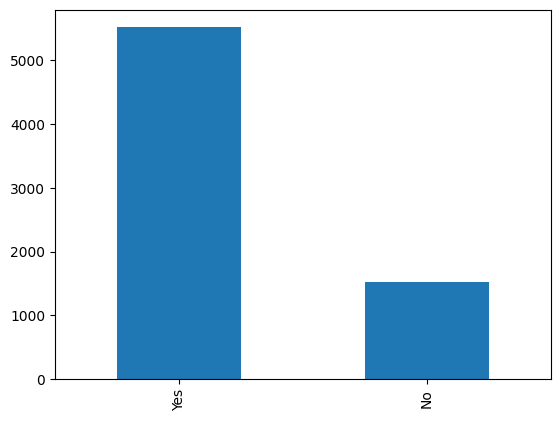

In [ ]:
tableNan['Internet'].value_counts().plot.bar()

<Axes: >

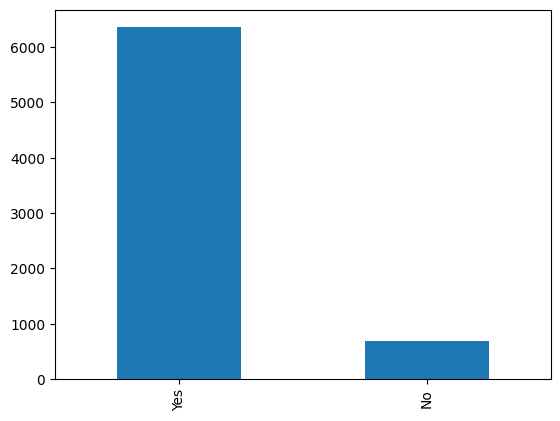

In [ ]:
tableNan['Phone'].value_counts().plot.bar()

<Axes: >

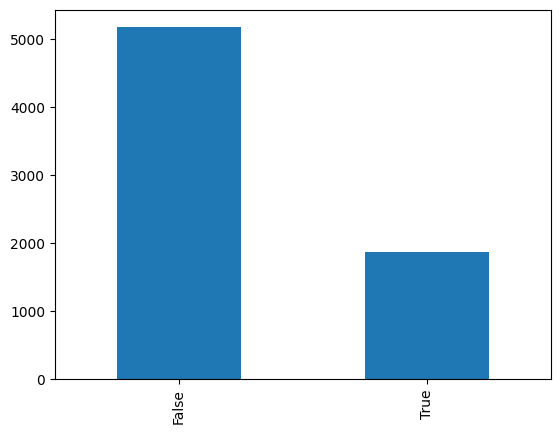

In [ ]:
tableNan['targetEnded'].value_counts().plot.bar()

<Axes: >

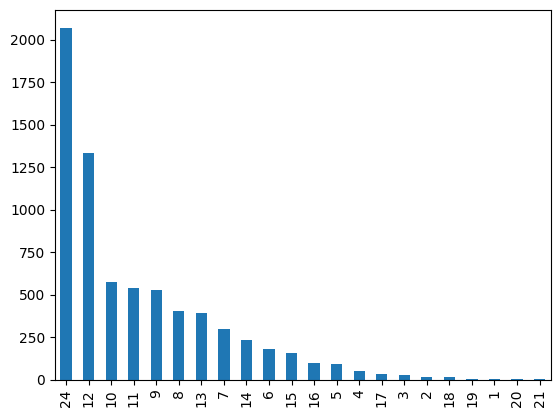

In [ ]:
tableNan['dtTemp'].value_counts().plot.bar()

<Axes: >

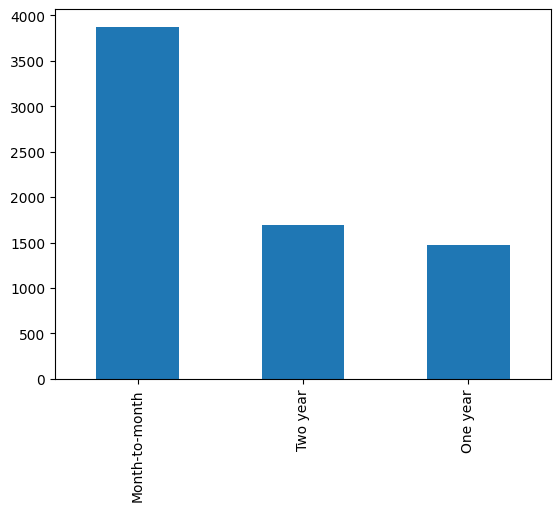

In [ ]:
tableNan['Type'].value_counts().plot.bar()

<Axes: >

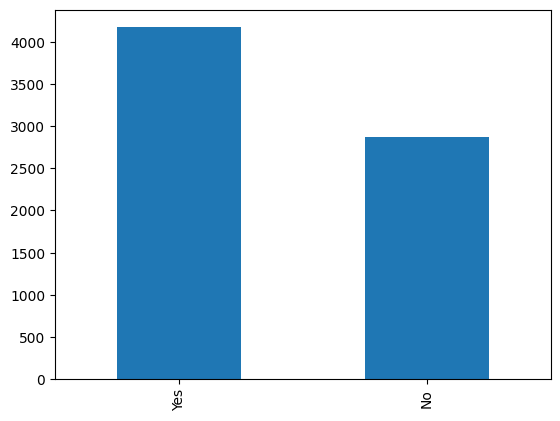

In [ ]:
tableNan['PaperlessBilling'].value_counts().plot.bar()

<Axes: >

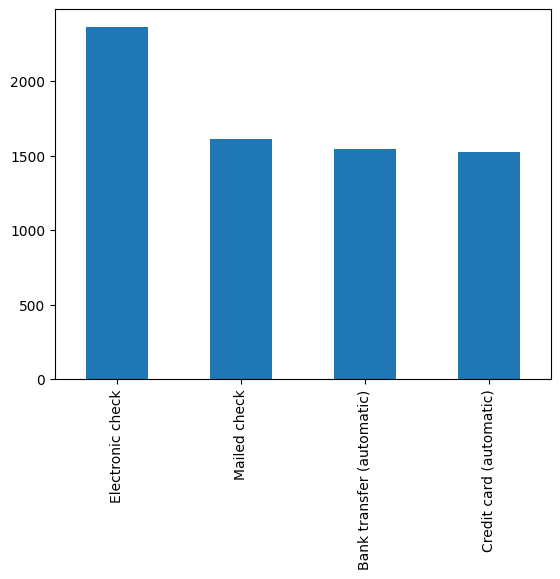

In [ ]:
tableNan['PaymentMethod'].value_counts().plot.bar()

<Axes: xlabel='nBreak'>

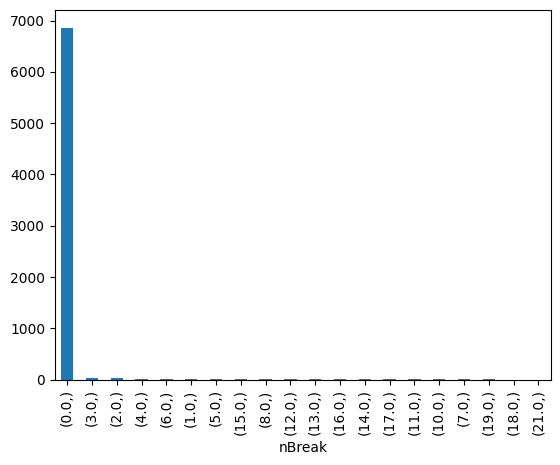

In [ ]:
tableNan[['nBreak']].value_counts().plot.bar()

колонка **nBreak** нужна была для исследования, но для вычислений можно от неё избавиться

<Axes: xlabel='gender'>

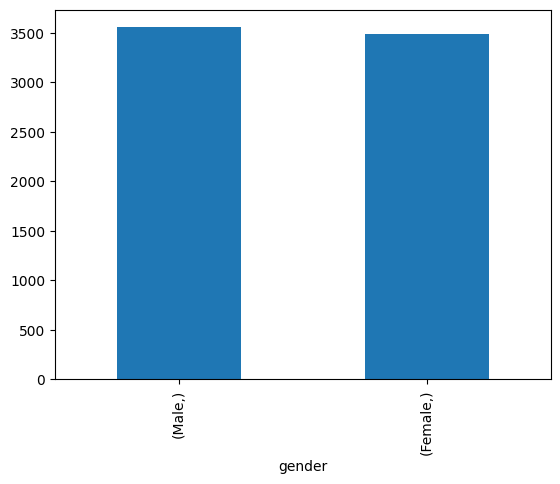

In [ ]:
tableNan[['gender']].value_counts().plot.bar()

<Axes: xlabel='SeniorCitizen'>

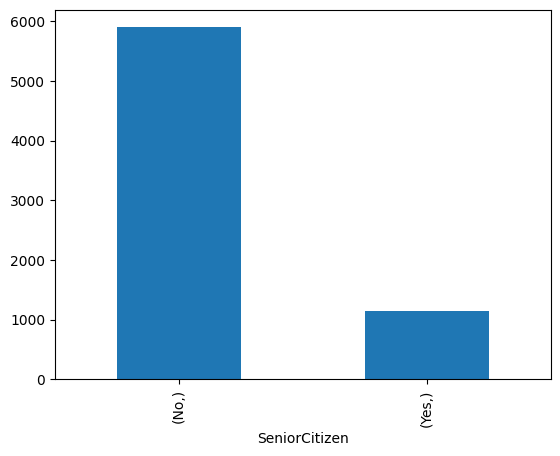

In [ ]:
tableNan[['SeniorCitizen']].value_counts().plot.bar()

<Axes: xlabel='Partner'>

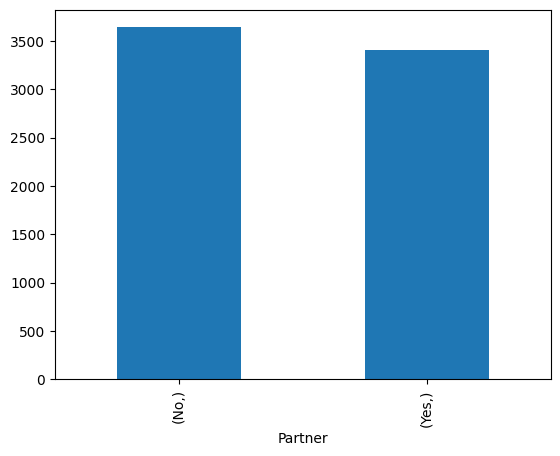

In [ ]:
tableNan[['Partner']].value_counts().plot.bar()

<Axes: xlabel='Dependents'>

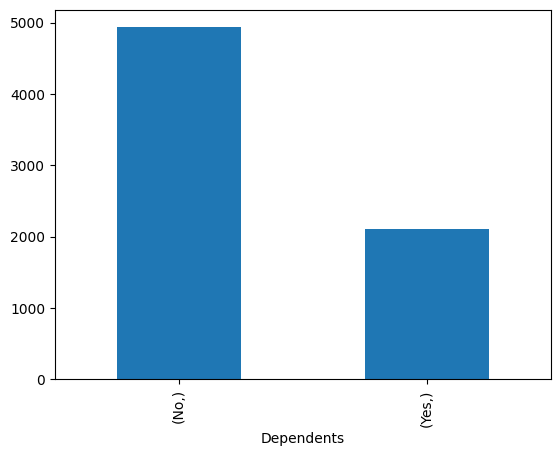

In [ ]:
tableNan[['Dependents']].value_counts().plot.bar()

<Axes: xlabel='InternetService'>

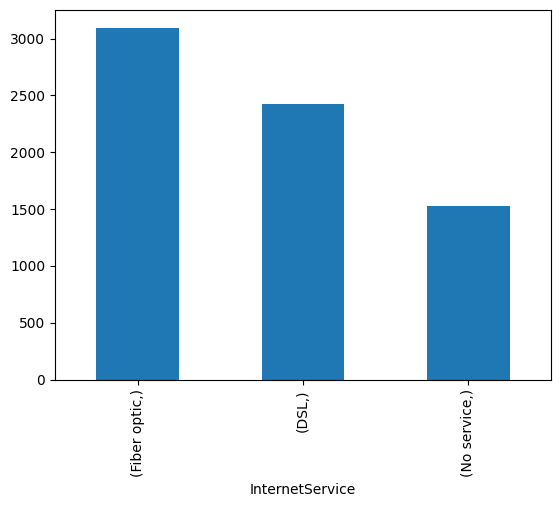

In [ ]:
tableNan[['InternetService']].value_counts().plot.bar()

<Axes: xlabel='OnlineSecurity'>

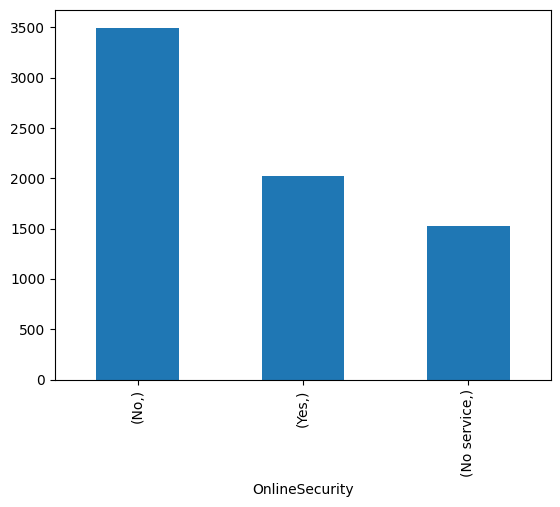

In [ ]:
tableNan[['OnlineSecurity']].value_counts().plot.bar()

<Axes: xlabel='OnlineBackup'>

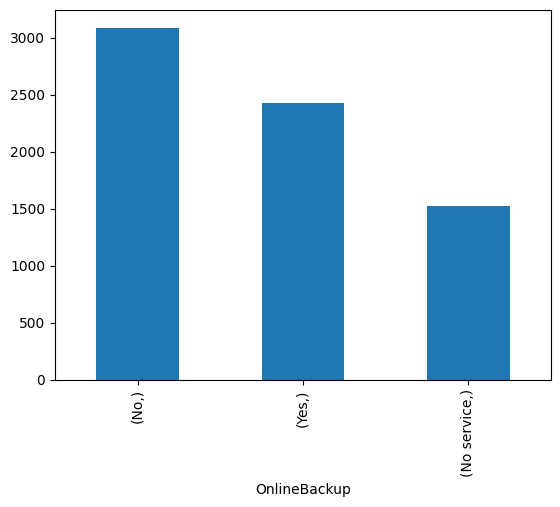

In [ ]:
tableNan[['OnlineBackup']].value_counts().plot.bar()

<Axes: xlabel='DeviceProtection'>

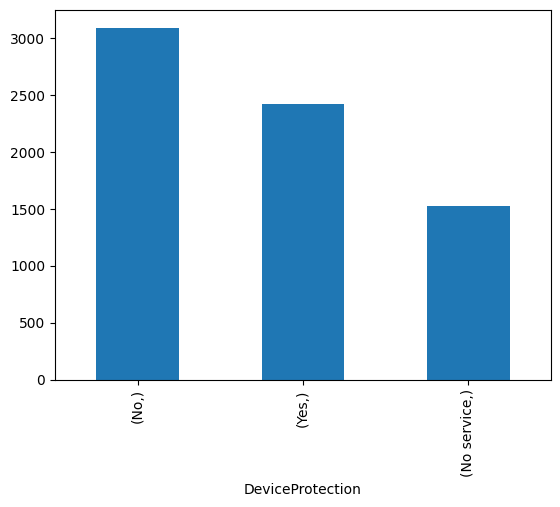

In [ ]:
tableNan[['DeviceProtection']].value_counts().plot.bar()

<Axes: xlabel='TechSupport'>

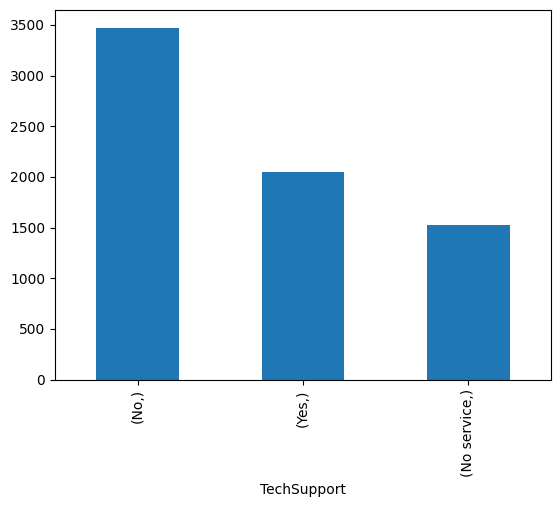

In [ ]:
tableNan[['TechSupport']].value_counts().plot.bar()

<Axes: xlabel='StreamingTV'>

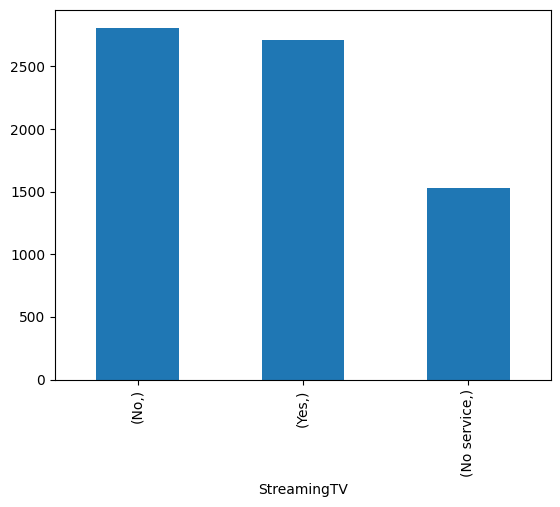

In [ ]:
tableNan[['StreamingTV']].value_counts().plot.bar()

<Axes: xlabel='StreamingMovies'>

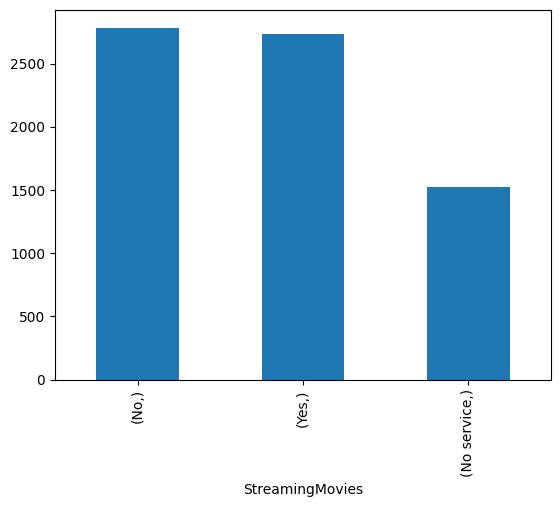

In [ ]:
tableNan[['StreamingMovies']].value_counts().plot.bar()

<Axes: xlabel='MultipleLines'>

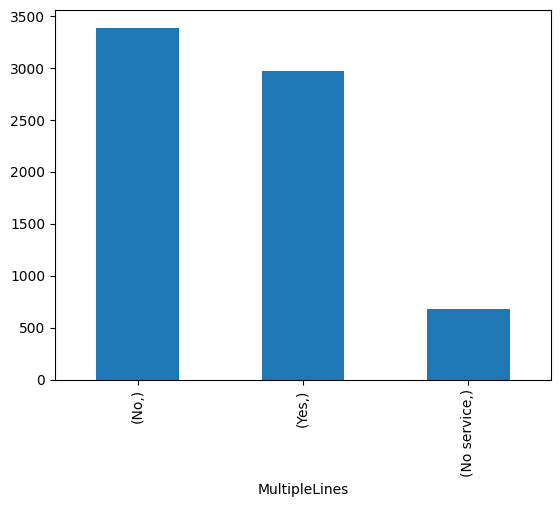

In [ ]:
tableNan[['MultipleLines']].value_counts().plot.bar()

Вывод: пропуски заполнены и распределение столбцов визуализировано

2.9 Визуализием соотношение ушедших и оставшихся клиентов для каждого признака

<Axes: xlabel='targetEnded,Internet'>

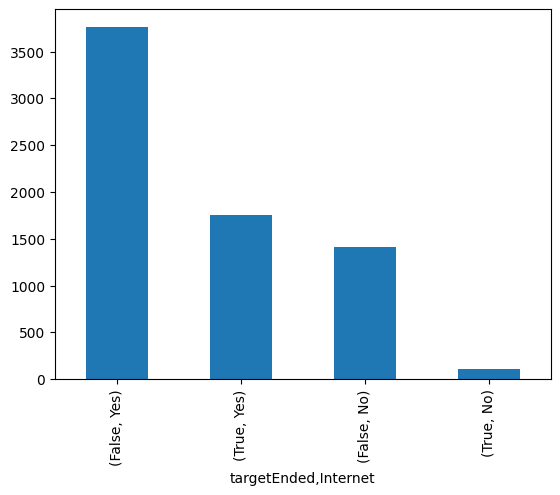

In [ ]:
tableNan[['targetEnded','Internet']].value_counts().plot.bar()

<Axes: xlabel='targetEnded,Phone'>

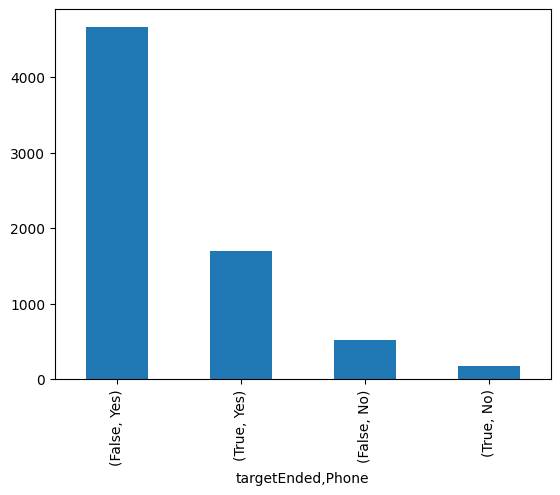

In [ ]:
tableNan[['targetEnded','Phone']].value_counts().plot.bar()

<Axes: xlabel='targetEnded,Internet'>

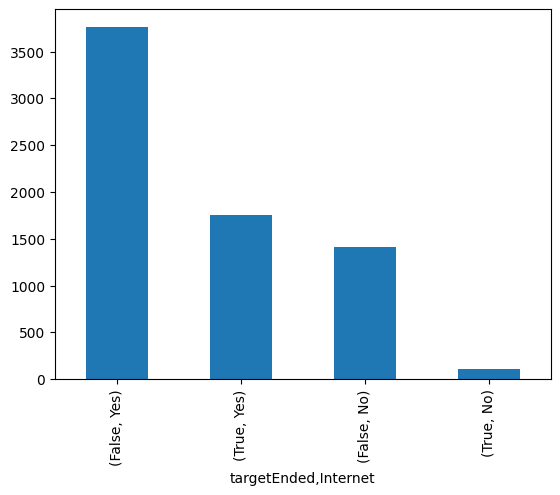

In [ ]:
tableNan[['targetEnded','Internet']].value_counts().plot.bar()

<Axes: xlabel='targetEnded,Type'>

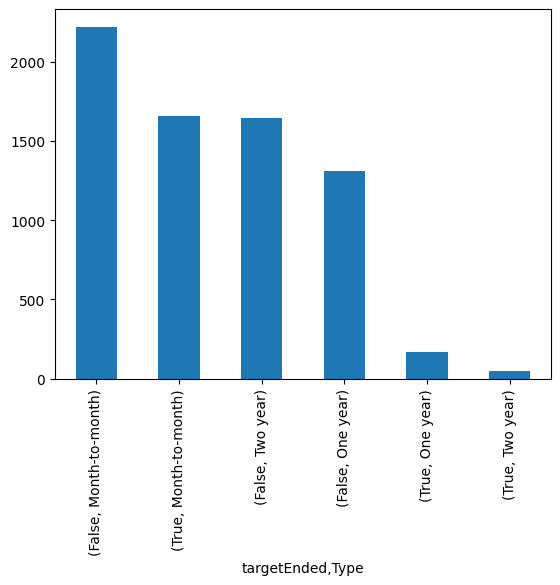

In [ ]:
tableNan[['targetEnded','Type']].value_counts().plot.bar()

<Axes: xlabel='targetEnded,PaperlessBilling'>

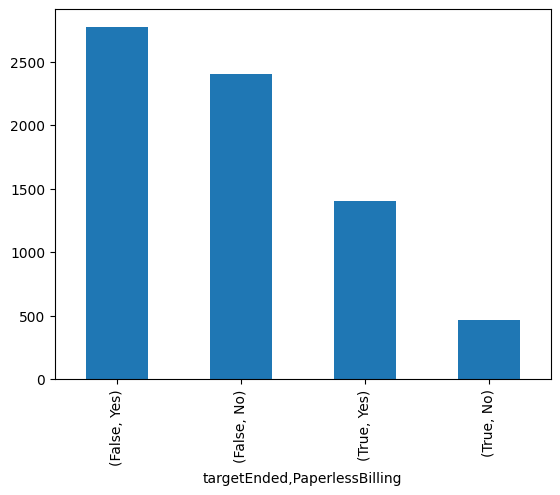

In [ ]:
tableNan[['targetEnded','PaperlessBilling']].value_counts().plot.bar()

<Axes: xlabel='targetEnded,PaymentMethod'>

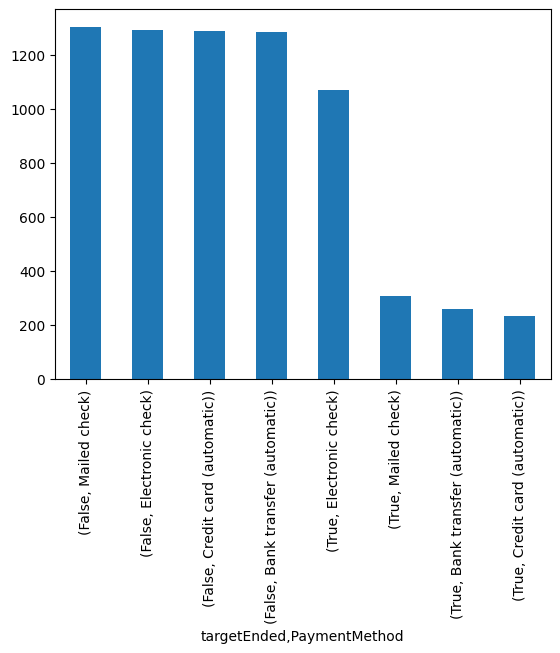

In [ ]:
tableNan[['targetEnded','PaymentMethod']].value_counts().plot.bar()

<Axes: xlabel='targetEnded,gender'>

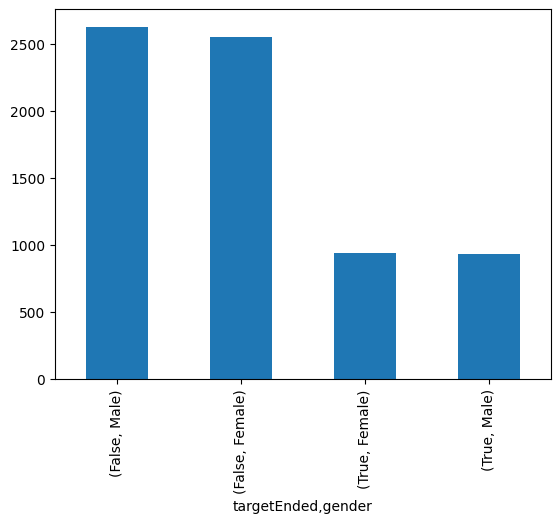

In [ ]:
tableNan[['targetEnded','gender']].value_counts().plot.bar()

<Axes: xlabel='targetEnded,SeniorCitizen'>

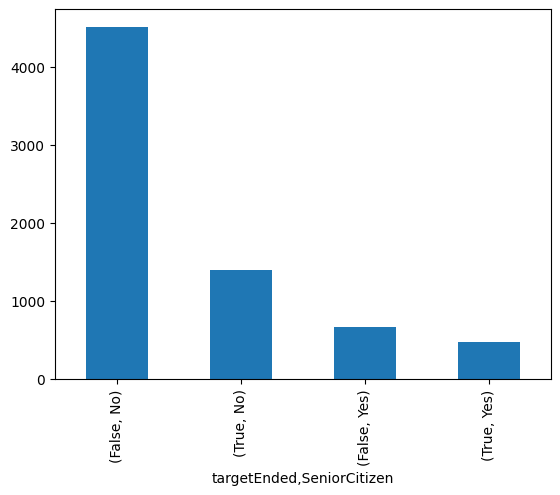

In [ ]:
tableNan[['targetEnded','SeniorCitizen']].value_counts().plot.bar()

<Axes: xlabel='targetEnded,Partner'>

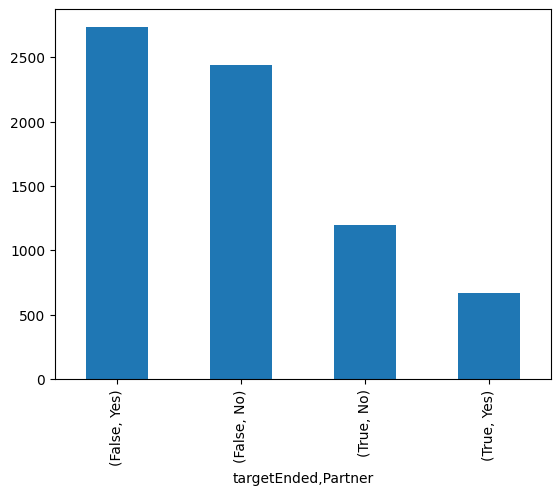

In [ ]:
tableNan[['targetEnded','Partner']].value_counts().plot.bar()

<Axes: xlabel='targetEnded,Dependents'>

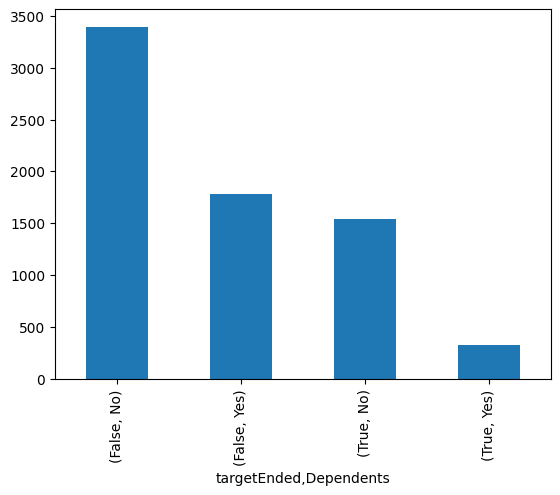

In [ ]:
tableNan[['targetEnded','Dependents']].value_counts().plot.bar()

<Axes: xlabel='targetEnded,InternetService'>

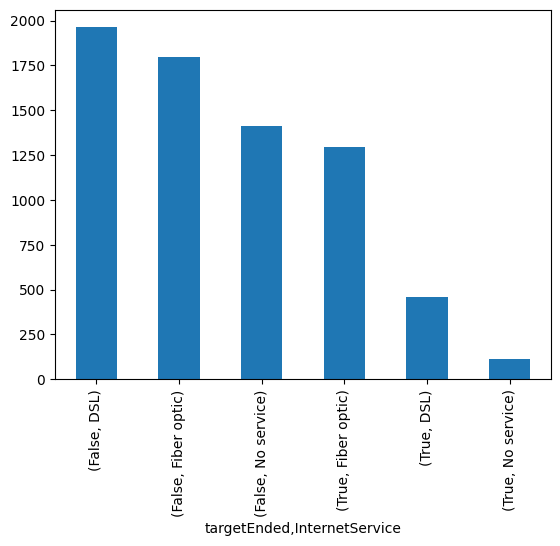

In [ ]:
tableNan[['targetEnded','InternetService']].value_counts().plot.bar()

<Axes: xlabel='targetEnded,OnlineSecurity'>

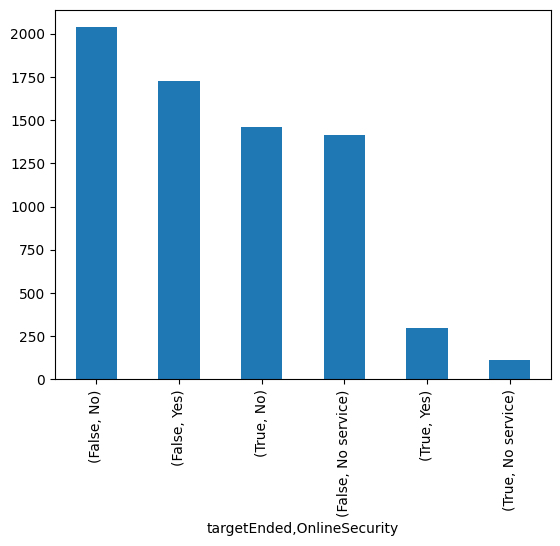

In [ ]:
tableNan[['targetEnded','OnlineSecurity']].value_counts().plot.bar()

<Axes: xlabel='targetEnded,OnlineBackup'>

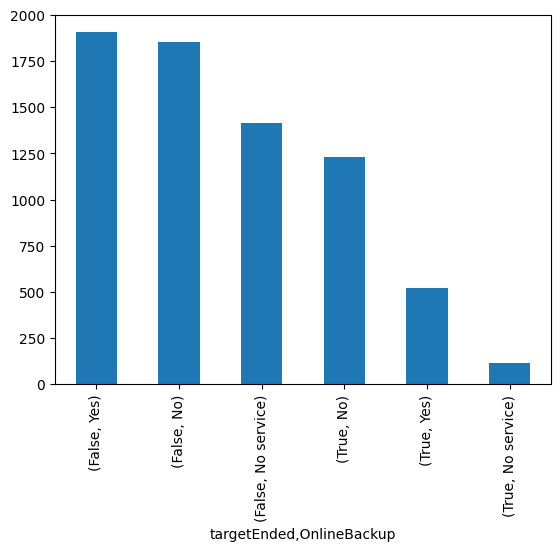

In [ ]:
tableNan[['targetEnded','OnlineBackup']].value_counts().plot.bar()

<Axes: xlabel='targetEnded,DeviceProtection'>

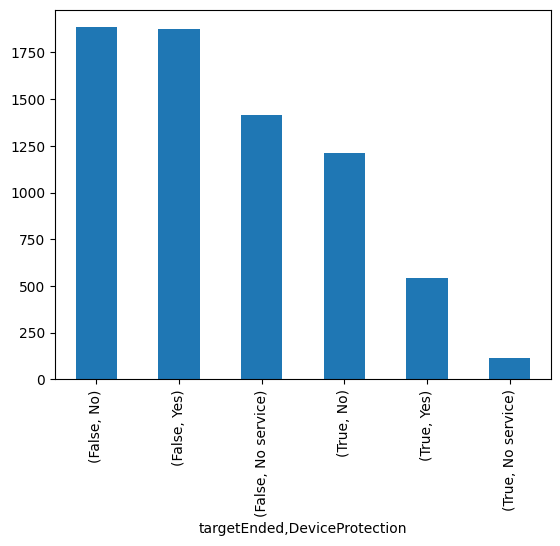

In [ ]:
tableNan[['targetEnded','DeviceProtection']].value_counts().plot.bar()

<Axes: xlabel='targetEnded,TechSupport'>

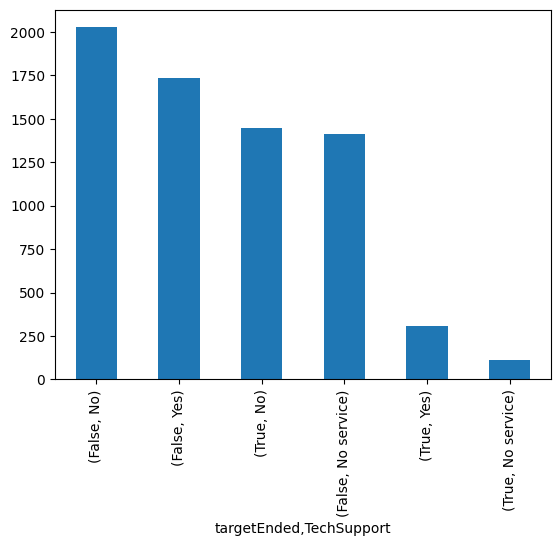

In [ ]:
tableNan[['targetEnded','TechSupport']].value_counts().plot.bar()

<Axes: xlabel='targetEnded,StreamingTV'>

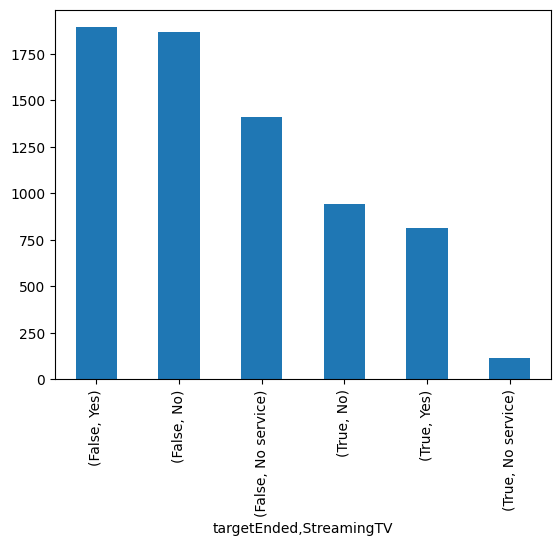

In [ ]:
tableNan[['targetEnded','StreamingTV']].value_counts().plot.bar()

<Axes: xlabel='targetEnded,StreamingMovies'>

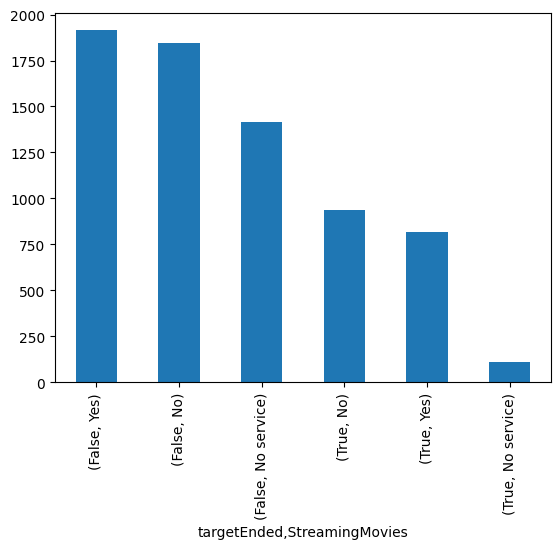

In [ ]:
tableNan[['targetEnded','StreamingMovies']].value_counts().plot.bar()

<Axes: xlabel='targetEnded,MultipleLines'>

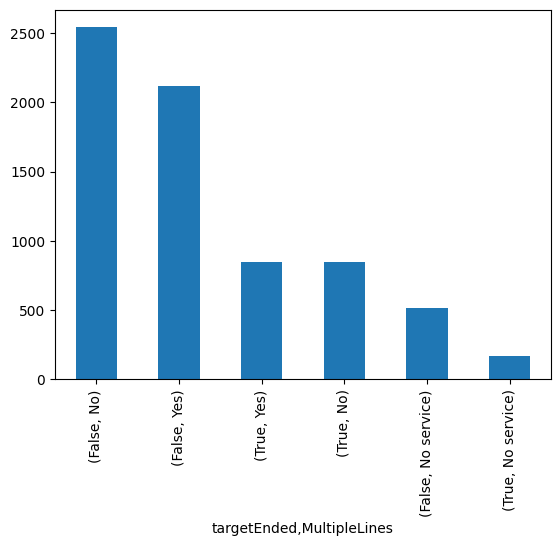

In [ ]:
tableNan[['targetEnded','MultipleLines']].value_counts().plot.bar()

Вывод: пересечения каждой колонки  **targetEnded** визуализированы

2.10 Проведем корреляционный анализ

перевод категорий строк в целочисленные индексы

In [ ]:
tableShow = tableNan[['targetEnded','Internet', 'Phone', 'BeginDate', 'EndDate',
       'EndDateTemp', 'dtReal', 'dtTemp', 'Type',
       'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges',
       'TotalChargesTemp', 'gender', 'SeniorCitizen', 'Partner',
       'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'MultipleLines']].apply(lambda x: pd.Categorical(x).codes, axis=0)

In [ ]:
tableShow.corr()

,targetEnded,Internet,Phone,BeginDate,EndDate,EndDateTemp,dtReal,dtTemp,Type,PaperlessBilling,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
targetEnded,1.000000,0.227890,0.011942,-0.384748,0.887655,-0.444680,0.944190,-0.488762,-0.396713,0.191825,...,-0.150448,-0.164221,-0.047291,-0.289309,-0.195525,-0.178134,-0.282492,-0.036581,-0.038492,0.038037
Internet,0.227890,1.000000,-0.172209,-0.078286,0.198710,-0.237452,0.216676,-0.235198,-0.242388,0.321013,...,-0.000615,-0.139812,-0.803477,-0.128453,-0.055914,-0.057116,-0.123866,-0.008691,-0.004472,0.272964
Phone,0.011942,-0.172209,1.000000,-0.010461,0.000706,-0.004542,0.011588,-0.004127,0.002247,0.016505,...,0.017706,-0.001762,0.387436,-0.015198,0.024105,0.003727,-0.019158,0.055353,0.043870,-0.020538
BeginDate,-0.384748,-0.078286,-0.010461,1.000000,-0.255194,0.242667,-0.516594,-0.160621,0.158664,-0.055491,...,0.069818,0.065932,0.008904,0.116664,0.089686,0.083672,0.125086,0.016441,0.030480,-0.022545
EndDate,0.887655,0.198710,0.000706,-0.255194,1.000000,-0.393172,0.837603,-0.434249,-0.355996,0.170012,...,-0.134043,-0.147486,-0.042165,-0.262133,-0.171021,-0.155044,-0.254067,-0.039377,-0.035126,0.026471
EndDateTemp,-0.444680,-0.237452,-0.004542,0.242667,-0.393172,1.000000,-0.419866,0.883742,0.887433,-0.172148,...,0.266662,0.226633,0.097946,0.339321,0.243141,0.299285,0.375382,0.182888,0.185354,0.086528
dtReal,0.944190,0.216676,0.011588,-0.516594,0.837603,-0.419866,1.000000,-0.377544,-0.374040,0.176411,...,-0.145192,-0.156232,-0.047074,-0.277906,-0.184233,-0.169213,-0.271494,-0.038696,-0.046834,0.035184
dtTemp,-0.488762,-0.235198,-0.004127,-0.160621,-0.434249,0.883742,-0.377544,1.000000,0.811152,-0.178528,...,0.242060,0.213137,0.094297,0.322592,0.225799,0.273280,0.348268,0.161535,0.158334,0.074266
Type,-0.396713,-0.242388,0.002247,0.158664,-0.355996,0.887433,-0.374040,0.811152,1.000000,-0.176733,...,0.294806,0.243187,0.099721,0.374416,0.280980,0.350277,0.425367,0.227116,0.231226,0.110842
PaperlessBilling,0.191825,0.321013,0.016505,-0.055491,0.170012,-0.172148,0.176411,-0.178528,-0.176733,1.000000,...,-0.014877,-0.111377,-0.138625,-0.157641,-0.013370,-0.038234,-0.113600,0.096642,0.083700,0.165146


Вывод: кореляционный анализ показывает зависимость **targetEnded** от **EndDateTemp**

Проверка на нормальность

In [ ]:
def FNormalCheck(val):
    if(val > 0.005):
        return 'нормальное распределение'
    else:
        return 'не нормальное распределение'

In [ ]:
tableNan.loc[tableNan['TotalCharges']==1889.50]

,customerID,Internet,Phone,BeginDate,EndDate,EndDateTemp,targetEnded,dtReal,dtTemp,Type,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
1889,5575-GNVDE,Yes,Yes,2019-03-26,None,2020-03-26,False,NaN,12,One year,...,No,No,DSL,Yes,No,Yes,No,No,No,No


In [ ]:
tableShow = tableNan[['targetEnded','Internet', 'Phone', 'BeginDate', 'EndDate',
       'EndDateTemp', 'dtReal', 'dtTemp', 'Type',
       'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges',
       'TotalChargesTemp', 'gender', 'SeniorCitizen', 'Partner',
       'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'MultipleLines']].apply(lambda x: pd.Categorical(x).codes, axis=0)
tableShow.apply(lambda x: shapiro(x), axis = 0).iloc[1].apply(FNormalCheck)

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


targetEnded         не нормальное распределение
Internet            не нормальное распределение
Phone               не нормальное распределение
BeginDate           не нормальное распределение
EndDate             не нормальное распределение
EndDateTemp         не нормальное распределение
dtReal              не нормальное распределение
dtTemp              не нормальное распределение
Type                не нормальное распределение
PaperlessBilling    не нормальное распределение
PaymentMethod       не нормальное распределение
MonthlyCharges      не нормальное распределение
TotalCharges        не нормальное распределение
TotalChargesTemp    не нормальное распределение
gender              не нормальное распределение
SeniorCitizen       не нормальное распределение
Partner             не нормальное распределение
Dependents          не нормальное распределение
InternetService     не нормальное распределение
OnlineSecurity      не нормальное распределение
OnlineBackup        не нормальное распре

Вывод: будет использована phik корреляция, т.к. она лучше подходить для анализа нелинейных зависимостей.

Вычисление phik корреляция.

interval columns not set, guessing: ['targetEnded', 'Internet', 'Phone', 'BeginDate', 'EndDate', 'EndDateTemp', 'dtReal', 'dtTemp', 'Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'TotalChargesTemp', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']


,targetEnded,Internet,Phone,BeginDate,EndDate,EndDateTemp,dtReal,dtTemp,Type,PaperlessBilling,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
targetEnded,1.000000,0.349367,0.000000,0.515555,1.000000,0.593613,1.000000,0.697843,0.251639,0.295754,...,0.232930,0.253936,0.196202,0.211840,0.177422,0.170762,0.209021,0.139246,0.139522,0.021922
Internet,0.349367,1.000000,0.265727,0.116027,0.185549,0.311841,0.294760,0.315733,0.146647,0.482393,...,0.000000,0.216514,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.194547
Phone,0.000000,0.265727,1.000000,0.000000,0.007161,0.000000,0.000000,0.000000,0.000000,0.016811,...,0.019540,0.000000,0.278954,0.106021,0.103910,0.103604,0.106451,0.108565,0.106784,1.000000
BeginDate,0.515555,0.116027,0.000000,1.000000,0.498366,0.845425,0.779734,0.716459,0.188796,0.076563,...,0.106444,0.091143,0.149671,0.163284,0.142176,0.137540,0.175231,0.106080,0.118955,0.028891
EndDate,1.000000,0.185549,0.007161,0.498366,1.000000,0.495055,0.839360,0.574318,0.357462,0.156832,...,0.121753,0.133425,0.288479,0.308565,0.264696,0.254553,0.305119,0.210946,0.210911,0.037048
EndDateTemp,0.593613,0.311841,0.000000,0.845425,0.495055,1.000000,0.442078,0.794144,0.857807,0.228737,...,0.351148,0.298054,0.322516,0.425870,0.370953,0.413204,0.452224,0.337760,0.338194,0.103557
dtReal,1.000000,0.294760,0.000000,0.779734,0.839360,0.442078,1.000000,0.935748,0.431675,0.248346,...,0.195870,0.213758,0.355209,0.377741,0.324890,0.312588,0.372814,0.260850,0.262367,0.035547
dtTemp,0.697843,0.315733,0.000000,0.716459,0.574318,0.794144,0.935748,1.000000,0.811626,0.240573,...,0.343124,0.290422,0.330608,0.424542,0.368454,0.402175,0.447649,0.335829,0.337401,0.105941
Type,0.251639,0.146647,0.000000,0.188796,0.357462,0.857807,0.431675,0.811626,1.000000,0.106860,...,0.179736,0.147680,0.505187,0.636884,0.581660,0.631531,0.671629,0.549564,0.553556,0.244410
PaperlessBilling,0.295754,0.482393,0.016811,0.076563,0.156832,0.228737,0.248346,0.240573,0.106860,1.000000,...,0.013218,0.172593,0.231438,0.208320,0.195321,0.195687,0.200621,0.204717,0.202241,0.099953


<Axes: >

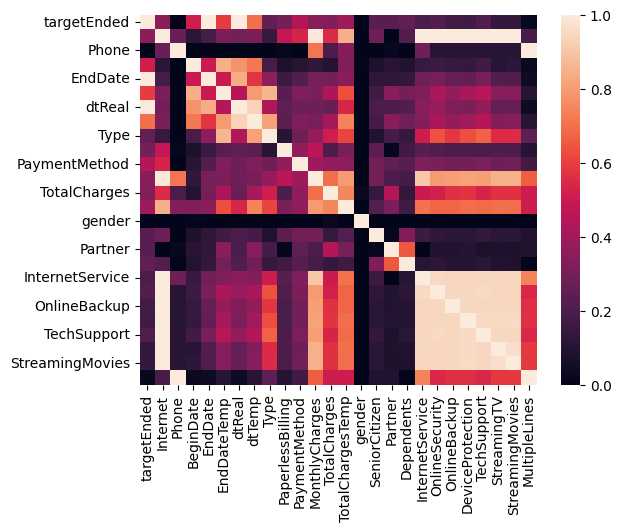

In [ ]:
tableShowPHIk = tableShow.phik_matrix()
display(tableShowPHIk)
display(heatmap(tableShowPHIk))

Зависимость искомого параметра от колонок

In [ ]:
sColumnsDep = tableShowPHIk['targetEnded'].apply(abs).iloc[1:].sort_values(ascending = False)
sColumnsDep

EndDate             1.000000
dtReal              1.000000
dtTemp              0.697843
EndDateTemp         0.593613
BeginDate           0.515555
PaymentMethod       0.449125
TotalChargesTemp    0.391792
Internet            0.349367
MonthlyCharges      0.342588
TotalCharges        0.329459
PaperlessBilling    0.295754
Dependents          0.253936
Type                0.251639
SeniorCitizen       0.233432
Partner             0.232930
OnlineSecurity      0.211840
TechSupport         0.209021
InternetService     0.196202
OnlineBackup        0.177422
DeviceProtection    0.170762
StreamingMovies     0.139522
StreamingTV         0.139246
MultipleLines       0.021922
Phone               0.000000
gender              0.000000
Name: targetEnded, dtype: float64

Вывод: кореляционный анализ показывает зависимость **targetEnded** от **dtTemp**

2.11 Подготовим выборки для обучения

убираются колонки с датами<br>
убираются "пустые" колонки<br>
убирается производная даты

In [ ]:
tablePreprocessing = tableNan.drop(columns=['BeginDate','EndDate','EndDateTemp'])
tablePreprocessing = tablePreprocessing.drop(columns=['dtReal','TotalCharges'])
tablePreprocessing = tablePreprocessing.drop(columns=['nBreak'])
tablePreprocessing = tablePreprocessing.drop(columns=['Internet','Phone'])
tablePreprocessing

,customerID,targetEnded,dtTemp,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalChargesTemp,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,4472-LVYGI,False,24,Two year,Yes,Bank transfer (automatic),52.55,1261.20,Female,No,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,No service
1,3115-CZMZD,False,24,Two year,No,Mailed check,20.25,486.00,Male,No,No,Yes,No service,No service,No service,No service,No service,No service,No service,No
2,3668-QPYBK,True,15,Month-to-month,Yes,Mailed check,53.85,807.75,Male,No,No,No,DSL,Yes,Yes,No,No,No,No,No
3,5709-LVOEQ,False,24,Two year,No,Mailed check,80.85,1940.40,Female,No,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No
4,9237-HQITU,True,9,Month-to-month,Yes,Electronic check,70.7,636.3,Female,No,No,No,Fiber optic,No,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,2569-WGERO,False,24,Two year,Yes,Bank transfer (automatic),21.15,507.60,Female,No,No,No,No service,No service,No service,No service,No service,No service,No service,No
7039,6840-RESVB,False,24,One year,Yes,Mailed check,84.8,2035.2,Male,No,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes
7040,2234-XADUH,False,12,One year,Yes,Credit card (automatic),103.2,1238.4,Female,No,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
7041,4801-JZAZL,False,9,Month-to-month,Yes,Electronic check,29.6,266.4,Female,No,Yes,Yes,DSL,Yes,No,No,No,No,No,No service


Разделим данные на тренировочную и тестовую выборки (test_size = 0.25)

In [ ]:
inTable = tablePreprocessing.drop(columns = ['customerID', 'targetEnded'])
outTable = tablePreprocessing[['targetEnded']]
inTrain, inTest, outTrain, outTest = train_test_split(inTable, outTable, test_size=0.25)

Добавление RANDOM_STATE в распределение

In [ ]:
inTable = tablePreprocessing.drop(columns = ['customerID', 'targetEnded'])
outTable = tablePreprocessing[['targetEnded']]
inTrain, inTest, outTrain, outTest = train_test_split(inTable, outTable, test_size=0.25, random_state = RANDOM_STATE)

выбираются категориальные столбцы, которые будут закодированны

In [ ]:
columns2OneHot = ['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']
columns2Scalar = ['dtTemp', 'MonthlyCharges', 'TotalChargesTemp']

эти столбцы кодируются

In [ ]:
dfEnc1 = list(map(lambda x: pd.get_dummies(x[columns2OneHot]), [inTrain, inTest]))

Используем OneHotEncoder, чтобы в разных датасетах не терялись значения

В OneHotEncoder для каждого признака убирается столбец с первым вариантом значения, значения этого столбца становятся своеобразными "точками отсчёта" (0), а последующие ктолбцы -- это оклонения от точки отсчёта.

In [ ]:
ohe = OneHotEncoder(drop = 'first', sparse_output = False, dtype = int)
dfEnc1Matrixes = [ohe.fit_transform(inTrain[columns2OneHot]), ohe.transform(inTest[columns2OneHot])]
dfEnc1 = [pd.DataFrame(dfEnc1Matrixes[0], columns = ohe.get_feature_names_out(), index = inTrain.index),
          pd.DataFrame(dfEnc1Matrixes[1], columns = ohe.get_feature_names_out(), index = inTest.index)]

In [ ]:
dfEnc1[0].columns

Index(['Type_One year', 'Type_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'gender_Male', 'SeniorCitizen_Yes', 'Partner_Yes', 'Dependents_Yes',
       'InternetService_Fiber optic', 'InternetService_No service',
       'OnlineSecurity_No service', 'OnlineSecurity_Yes',
       'OnlineBackup_No service', 'OnlineBackup_Yes',
       'DeviceProtection_No service', 'DeviceProtection_Yes',
       'TechSupport_No service', 'TechSupport_Yes', 'StreamingTV_No service',
       'StreamingTV_Yes', 'StreamingMovies_No service', 'StreamingMovies_Yes',
       'MultipleLines_No service', 'MultipleLines_Yes'],
      dtype='object')

In [ ]:
dfEnc1[1].columns

Index(['Type_One year', 'Type_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'gender_Male', 'SeniorCitizen_Yes', 'Partner_Yes', 'Dependents_Yes',
       'InternetService_Fiber optic', 'InternetService_No service',
       'OnlineSecurity_No service', 'OnlineSecurity_Yes',
       'OnlineBackup_No service', 'OnlineBackup_Yes',
       'DeviceProtection_No service', 'DeviceProtection_Yes',
       'TechSupport_No service', 'TechSupport_Yes', 'StreamingTV_No service',
       'StreamingTV_Yes', 'StreamingMovies_No service', 'StreamingMovies_Yes',
       'MultipleLines_No service', 'MultipleLines_Yes'],
      dtype='object')

In [ ]:
enc = StandardScaler()
enc.fit(inTrain[columns2Scalar])
dfEnc2 = list(map(lambda x: pd.DataFrame(enc.transform(x[columns2Scalar]),columns = columns2Scalar, index = x.index), [inTrain, inTest]))

In [ ]:
[inTrainEnc, inTestEnc] = list(map(lambda x: pd.concat([dfEnc1[x], dfEnc2[x]], axis = 1), range(2)))

In [ ]:
outTrainList = outTrain['targetEnded'].values.astype(int)
outTestList = outTest['targetEnded'].values.astype(int)

## Шаг 3. Обучим модель

### 3.1 DecisionTree<br>
ведётся поиск по возможным параметрам с методом оценки 'roc_auc' и выбирается наилучшая модель

In [ ]:
modelTree = GridSearchCV(tree.DecisionTreeClassifier(), {'criterion' : ['gini', 'entropy', 'log_loss'], 'max_depth' : [None, 1, 2, 3, 4, 5]}, scoring = 'roc_auc')
modelTree.fit(inTrainEnc, outTrainList)
modelTree.best_estimator_

DecisionTreeClassifier(max_depth=5)

### 3.2 Random Forest -- модель объединяющая в себе несколько DecisionTrees<br>
ведётся поиск по возможным параметрам с методом оценки 'roc_auc' и выбирается наилучшая модель

In [ ]:
modelForest = GridSearchCV(RandomForestClassifier(), {'n_estimators': [50, 100, 200], 'max_depth': [2, 3, 4, 5]}, scoring = 'roc_auc')
modelForest.fit(inTrainEnc, outTrainList)
modelForest.best_estimator_

RandomForestClassifier(max_depth=5)

### 3.3 Gradient Boosting<br>
ведётся поиск по возможным параметрам с методом оценки 'roc_auc' и выбирается наилучшая модель

In [ ]:
modelBoosting = GridSearchCV(GradientBoostingClassifier(), {'criterion' : ['friedman_mse', 'squared_error'], 'n_estimators': [50, 100, 200]}, scoring = 'roc_auc')
modelBoosting.fit(inTrainEnc, outTrainList)
modelBoosting.best_estimator_

GradientBoostingClassifier(n_estimators=50)

3.4 Нейросеть

In [ ]:
nn = Sequential([
    Dense(inTrainEnc.shape[1], activation = 'relu'),
    Dense(1),
])
nn.compile(optimizer = Adam(), loss = BinaryCrossentropy())
nn.fit(inTrainEnc, outTrainList, epochs = 10)

Epoch 1/10
166/166 [==============================] - 2s 3ms/step - loss: 0.8133
Epoch 2/10
166/166 [==============================] - 0s 3ms/step - loss: 0.5931
Epoch 3/10
166/166 [==============================] - 0s 2ms/step - loss: 0.4864
Epoch 4/10
166/166 [==============================] - 0s 2ms/step - loss: 0.4470
Epoch 5/10
166/166 [==============================] - 0s 2ms/step - loss: 0.4381
Epoch 6/10
166/166 [==============================] - 0s 2ms/step - loss: 0.4181
Epoch 7/10
166/166 [==============================] - 0s 2ms/step - loss: 0.4167
Epoch 8/10
166/166 [==============================] - 0s 2ms/step - loss: 0.4118
Epoch 9/10
166/166 [==============================] - 0s 2ms/step - loss: 0.4129
Epoch 10/10
166/166 [==============================] - 0s 2ms/step - loss: 0.4017


In [ ]:
def NNBuilder():
    nn = Sequential()
    nn.add(Dense(inTrainEnc.shape[1], input_dim = inTrainEnc.shape[1], activation = 'relu'))
    nn.add(Dense(inTrainEnc.shape[1] * 2, activation = 'relu'))
    nn.add(Dense(1, activation='sigmoid'))
    nn.compile(optimizer = Adam(), loss = BinaryCrossentropy(), metrics = 'accuracy')
    return(nn)

In [ ]:
modelNN = KerasRegressor(NNBuilder, epochs = 10, metrics = 'accuracy')
modelNN.fit(inTrainEnc, outTrainList)

Epoch 1/10
166/166 [==============================] - 1s 3ms/step - loss: 0.4349 - accuracy: 0.7796
Epoch 2/10
166/166 [==============================] - 0s 2ms/step - loss: 0.3851 - accuracy: 0.8065
Epoch 3/10
166/166 [==============================] - 0s 2ms/step - loss: 0.3776 - accuracy: 0.8103
Epoch 4/10
166/166 [==============================] - 0s 2ms/step - loss: 0.3743 - accuracy: 0.8164
Epoch 5/10
166/166 [==============================] - 0s 2ms/step - loss: 0.3705 - accuracy: 0.8150
Epoch 6/10
166/166 [==============================] - 0s 2ms/step - loss: 0.3666 - accuracy: 0.8194
Epoch 7/10
166/166 [==============================] - 0s 2ms/step - loss: 0.3665 - accuracy: 0.8190
Epoch 8/10
166/166 [==============================] - 0s 2ms/step - loss: 0.3630 - accuracy: 0.8226
Epoch 9/10
166/166 [==============================] - 0s 2ms/step - loss: 0.3613 - accuracy: 0.8213
Epoch 10/10
166/166 [==============================] - 0s 2ms/step - loss: 0.3585 - accuracy: 0.8241

KerasRegressor(
	model=<function NNBuilder at 0x7ffa60624c10>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=accuracy
	batch_size=None
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=10
)

## 4. Протестируем модель и продемонстрируем её работу

### 4.1 DecisionTree

In [ ]:
predictionTree = modelTree.best_estimator_.predict(inTestEnc)
scoreTree = metrics.roc_auc_score(predictionTree, outTestList)
scoreTreeA = metrics.accuracy_score(predictionTree, outTestList)
[scoreTree, scoreTreeA]

[0.7737037037037036, 0.8307779670641681]

Чтобы получилась кривая, используется не model.predict, а model predict_proba, потому что в первом случае возможны лишь результаты 1 или 0, которые потом вычитаются из 1, что не позволяет получить гладкую кривую. Поэтому получаю вероятности принадлежности входных данных  к классам 1 либо 0 и вычитаю вероятности принадлежности к 1 из 1, что позволит получить более гладкие значения

In [ ]:
probaTree = modelTree.best_estimator_.predict_proba(inTestEnc)
predictionTree = modelTree.best_estimator_.predict(inTestEnc)
scoreTree = metrics.roc_auc_score(outTestList, probaTree[:, 1])
scoreTreeA = metrics.accuracy_score(outTestList, predictionTree)
[scoreTree, scoreTreeA]

[0.8934068410741839, 0.8307779670641681]

### 4.2 Random Forest

In [ ]:
predictionForest = modelForest.best_estimator_.predict(inTestEnc)
scoreForest = metrics.roc_auc_score(predictionForest, outTestList)
scoreForestA = metrics.accuracy_score(predictionForest, outTestList)
[scoreForest, scoreForestA]

[0.7753896871069782, 0.8302101078932425]

### 4.3 Gradient Boosting

In [ ]:
predictionBoosting = modelBoosting.best_estimator_.predict(inTestEnc)
scoreBoosting = metrics.roc_auc_score(predictionBoosting, outTestList)
scoreBoostingA = metrics.accuracy_score(predictionBoosting, outTestList)
[scoreBoosting, scoreBoostingA]

[0.7894233785943074, 0.8415672913117547]

### 4.4 Нейросеть

In [ ]:
predictionNn = nn.predict(inTestEnc)
scoreNn = metrics.roc_auc_score(predictionBoosting, outTestList)
scoreNnA = metrics.accuracy_score(predictionBoosting, outTestList)
[scoreNn, scoreNnA]

56/56 [==============================] - 0s 1ms/step


[0.7894233785943074, 0.8415672913117547]

Вывод: Random Forest имеет лучшую `roc_auc` оценку

In [ ]:
models = [modelTree.best_estimator_, modelForest.best_estimator_, modelBoosting.best_estimator_, modelNN]
modelsNames = ['DecisionTree', 'RandomForest', 'GradientBoosting', 'Нейросеть']
cvTestList = []
for i in models:
    cvTestList.append(cross_val_score(i, inTrainEnc, outTrainList, scoring = 'roc_auc'))

Epoch 1/10
133/133 [==============================] - 1s 3ms/step - loss: 0.4749 - accuracy: 0.7493
Epoch 2/10
133/133 [==============================] - 0s 2ms/step - loss: 0.3933 - accuracy: 0.8009
Epoch 3/10
133/133 [==============================] - 0s 2ms/step - loss: 0.3845 - accuracy: 0.8052
Epoch 4/10
133/133 [==============================] - 0s 2ms/step - loss: 0.3789 - accuracy: 0.8071
Epoch 5/10
133/133 [==============================] - 0s 2ms/step - loss: 0.3751 - accuracy: 0.8144
Epoch 6/10
133/133 [==============================] - 0s 2ms/step - loss: 0.3699 - accuracy: 0.8185
Epoch 7/10
133/133 [==============================] - 0s 2ms/step - loss: 0.3677 - accuracy: 0.8175
Epoch 8/10
133/133 [==============================] - 0s 2ms/step - loss: 0.3687 - accuracy: 0.8180
Epoch 9/10
133/133 [==============================] - 0s 2ms/step - loss: 0.3615 - accuracy: 0.8208
Epoch 10/10
34/34 [==============================] - 0s 2ms/step
Epoch 1/10
133/133 [===============

In [ ]:
cvTestList

[array([0.88047875, 0.87020001, 0.90523794, 0.87713579, 0.86690711]),
 array([0.88311688, 0.86657315, 0.90276769, 0.88257069, 0.86657408]),
 array([0.88803792, 0.87903299, 0.91058487, 0.8928696 , 0.88197487]),
 array([0.8738447 , 0.86217254, 0.89881975, 0.87345801, 0.87063253])]

In [ ]:
dfModelsCV = pd.DataFrame(np.transpose([np.array(modelsNames, dtype = object), np.array(models, dtype = object), list(map(max, cvTestList))]), columns = ['name', 'model', 'best_score']).sort_values(by = 'best_score', ascending = False)
dfModelsCV

,name,model,best_score
2,GradientBoosting,([DecisionTreeRegressor(criterion='friedman_ms...,0.910585
0,DecisionTree,DecisionTreeClassifier(max_depth=5),0.905238
1,RandomForest,"(DecisionTreeClassifier(max_depth=5, max_featu...",0.902768
3,Нейросеть,KerasRegressor(\n\tmodel=<function NNBuilder a...,0.89882


In [ ]:
modelMain = dfModelsCV.iloc[0]['model']
predictionMain = modelMain.predict(inTestEnc)
probaMain = modelMain.predict_proba(inTestEnc)
scoreMain = metrics.roc_auc_score(outTestList, probaMain[:, 1])
scoreMainA = metrics.accuracy_score(outTestList, predictionMain)
[scoreMain, scoreMainA]

[0.9084819958045109, 0.8415672913117547]

Вывод: на кросс-валидации автоматически выбрана лучшая модель:

In [ ]:
print('лучшая модель:', dfModelsCV.iloc[0]['name'])
print('roc auc на тестовой выборке: ', scoreMain)
print('accuracy на тестовой выборке: ', scoreMainA)

лучшая модель: GradientBoosting
roc auc на тестовой выборке:  0.9084819958045109
accuracy на тестовой выборке:  0.8415672913117547


### 4.5 Построим матрицу ошибок лучшей модели. Отобразим полноту и точность модели на графике.

In [ ]:
metrics.confusion_matrix(predictionMain, predictionMain)

array([[1357,    0],
       [   0,  404]])

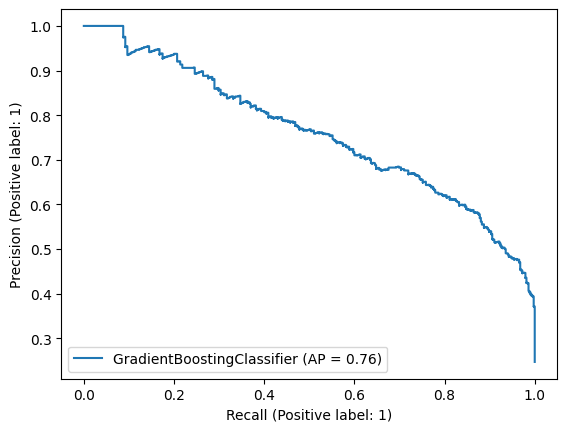

In [ ]:
metrics.PrecisionRecallDisplay.from_estimator(modelMain, inTestEnc, outTestList)

### 4.6 Проанализируем важность основных входных признаков, влияющих на отток клиентов.

In [ ]:
dfFeatureImportance = pd.DataFrame(np.transpose([inTrainEnc.columns, modelMain.feature_importances_]), columns = ['feature', 'importance'])
dfFeatureImportance = dfFeatureImportance.sort_values(by = 'importance', ascending = False)
dfFeatureImportance

,feature,importance
26,dtTemp,0.661836
0,Type_One year,0.083426
10,InternetService_Fiber optic,0.071647
4,PaymentMethod_Electronic check,0.046321
28,TotalChargesTemp,0.030483
1,Type_Two year,0.023265
19,TechSupport_Yes,0.015439
13,OnlineSecurity_Yes,0.013956
27,MonthlyCharges,0.012827
2,PaperlessBilling_Yes,0.012781


### 4.7 Для одного из важных входных признаков проведем дополнительное исследование: Покажем график зависимости входного и целевого признаков.

<Axes: >

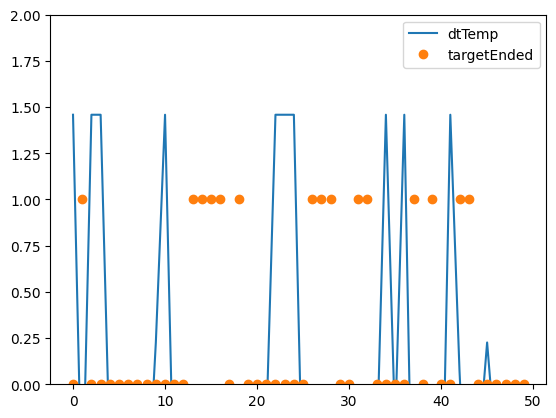

In [ ]:
dfEndShowcase = pd.DataFrame(np.transpose([inTrainEnc['dtTemp'].tolist(), outTrainList]), columns = ['dtTemp', 'targetEnded'])
dfEndShowcase[:50].plot(y = dfEndShowcase.columns, ylim = [0, 2], style=['-', 'o'])

<Axes: >

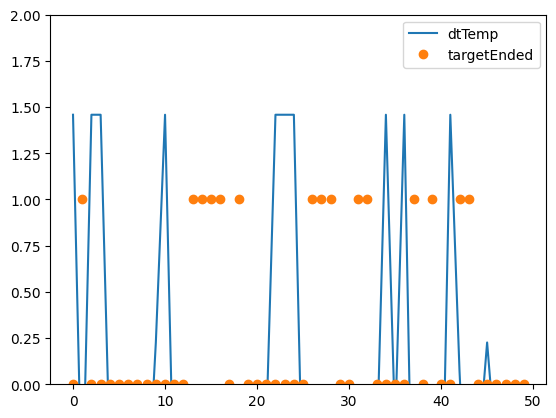

In [ ]:
dfEndShowcase = pd.DataFrame(np.transpose([inTrainEnc[dfFeatureImportance.iloc[0]['feature']].tolist(), outTrainList]), columns = [dfFeatureImportance.iloc[0]['feature'], 'targetEnded'])
dfEndShowcase[:50].plot(y = dfEndShowcase.columns, ylim = [0, 2], style=['-', 'o'])

## 5. Вывод:

По заданию, необходимо было разработать модель для оператора связи, которая будет предсказывать, разорвет ли абонент договор. Были собраны персональные данные о некоторых клиентах, информация об их тарифах и услугах. Задача была - обучить на этих данных модель для прогноза оттока клиентов.

Данные были загружены подключившись к базе данных. Проведен исследовательский анализ данных и предобработка данных. Каждая таблица содержала данных, все они использовались в проекте. В первой таблице присутствовали нулевые значения, они были обработаны.

Была выделена целевая переменная признак EndDate. Были сгенерированы новые признаки, рассчитана длительность контракта абонента. Добавили признак "Остаток месяцев при прирывании услуги" - nBreak.

Выявлено, что столбец SeniorCitizen не категориальный, а числовой, заменили 1 на "Yes", 0 на "No".

Таблицы объединены по id.
Провели корреляционный анализ, который показал зависимость targetEnded от EndDateTemp.

Подготовили выборки для обучения. Обучили модели, выбраны DecisionTree, Random Forest, Gradient Boosting, Нейросеть.

Протестировали модели, Random Forest показал лучшую roc_auc оценку.
Проанализировали важность основных входных признаков, влияющих на отток клиентов.

Для одного из важных входных признаков проведено дополнительное исследование: показан график зависимости входного и целевого признаков.

В целом, бизнес-рекомендация компании «ТелеДом» использовать модель для прогнозирования оттока клиента. С целью увеличить точность работы модели, рекомендуется использовать больший по размеру датасет.